<a href="https://colab.research.google.com/github/ttjh1234/CSproject_SDA/blob/main/Revision_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Revision Task

## 필요라이브러리 임포트

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
import re

미리 저장한 전처리된 데이터 로드

In [ ]:
test3=np.load("./drive/MyDrive/data_extract/xyuseadd.npz")
x_re=test3['x']
y_re=test3['y']

In [ ]:
print(x_re.shape, y_re.shape)

(5654, 30, 16, 2) (5654,)


In [ ]:
np.unique(y_re)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 52, 53, 54, 55])

라벨 재조정

In [ ]:
for i,value in enumerate(y_re):
  if(value==52):
    y_re[i]=44
  if(value==53):
    y_re[i]=45
  if(value==54):
    y_re[i]=46
  if(value==55):
    y_re[i]=47

In [ ]:
for i,value in enumerate(y_re):
  if(value==45):
    y_re[i]=1
  else:
    y_re[i]=0  

In [ ]:
np.unique(y_re)

array([0, 1])

In [ ]:
np.sum(y_re[y_re==1])

1299

In [ ]:
x_3d=x_re.reshape(5654*30,16,2)

3d pose baseline 로드 및 적합

In [ ]:
my3d=keras.models.load_model("./drive/MyDrive/save_model/3dpose")
x_3d=my3d.predict(x_3d)

In [ ]:
x_3d.shape

(169620, 51)

In [ ]:
x2=x_3d.reshape(5654*30,51)

In [ ]:
testx2=x2[0]

In [ ]:
testx2.shape

(51,)

In [ ]:
testx2

array([-0.15011945, -0.15462281,  2.0201716 , -0.11060666, -0.15295066,
        2.01794   ,  0.05088106, -0.31537756,  1.9797015 ,  0.05327906,
       -0.59467137,  1.9747022 , -0.18457893, -0.15128613,  1.958997  ,
       -0.12140158, -0.32907462,  1.907788  , -0.11464664, -0.57552296,
        1.8832983 , -0.14387062,  0.3273005 ,  2.0072355 , -0.14661978,
        0.12408856,  2.0166483 , -0.14279191,  0.3932371 ,  2.0016294 ,
       -0.12218884,  0.49784666,  2.0469646 , -0.19675174,  0.25680655,
        1.9006636 , -0.14355299,  0.09553894,  1.8908932 , -0.13361858,
        0.0119729 ,  1.9068078 , -0.06299327,  0.27372247,  2.0556185 ,
       -0.01615454,  0.12982321,  2.0185814 ,  0.05368672,  0.0838541 ,
        2.0523815 ], dtype=float32)

In [ ]:
testx2.reshape(17,3)

array([-0.15011945, -0.15462281,  2.0201716 ], dtype=float32)

In [ ]:
x=x_3d.reshape(5654*30,17,3)

In [ ]:
x=x.reshape(5654,30,17,3)

In [ ]:
x.shape

(5654, 30, 17, 3)

## STGCN 모델

In [ ]:
class Graph:
    def __init__(self, labeling_mode='spatial'):
        self.num_node = 17
        self.self_link = [(i, i) for i in range(self.num_node)]
        self.inward_ori_index = [(1, 2), (1,5),(1,9),(2,3),(3,4),(5,6),(6,7),(8,9),(8,10),(8,12),(8,15),(10,11),(12,13),(13,14),(15,16),(16,17)]
        self.inward = [(i - 1, j - 1) for (i, j) in self.inward_ori_index]
        self.outward = [(j, i) for (i, j) in self.inward]
        self.neighbor = self.inward+self.outward
        self.A = self.get_adjacency_matrix(labeling_mode)

    def edge2mat(self,link, num_node):
        A = np.zeros((num_node, num_node))
        for i, j in link:
            A[j, i] = 1
        return A
    def normalize_digraph(self,A):  
        Dl = np.sum(A, 0)
        h, w = A.shape
        Dn = np.zeros((w, w))
        for i in range(w):
            if Dl[i] > 0:
                Dn[i, i] = Dl[i] ** (-1)
        AD = np.dot(A, Dn)
        return AD

    def get_spatial_graph(self,num_node, self_link, inward, outward):
        I = self.edge2mat(self_link, num_node)
        In = self.normalize_digraph(self.edge2mat(inward, num_node))
        Out = self.normalize_digraph(self.edge2mat(outward, num_node))
        A = np.stack((I, In, Out))
        return A

    def get_adjacency_matrix(self, labeling_mode=None):
        if labeling_mode is None:
            return self.A
        if labeling_mode == 'spatial':
            A = self.get_spatial_graph(self.num_node, self.self_link, self.inward, self.outward)
        else:
            raise ValueError()
        return A

In [ ]:
import tensorflow as tf
import numpy as np

REGULARIZER = tf.keras.regularizers.l2(l=0.0001)
INITIALIZER = tf.keras.initializers.VarianceScaling(scale=2.,
                                                    mode="fan_out",
                                                    distribution="truncated_normal")

In [ ]:
class SGCN(tf.keras.Model):
    def __init__(self, filters, kernel_size=3):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv2D(filters*kernel_size,
                                           kernel_size=3,
                                           padding='same',
                                           kernel_initializer=INITIALIZER,
                                           data_format='channels_first',
                                           kernel_regularizer=REGULARIZER)

    # N, C, T, V
    def call(self, x, A, training):
        x = self.conv(x)

        N = tf.shape(x)[0]
        C = tf.shape(x)[1]
        T = tf.shape(x)[2]
        V = tf.shape(x)[3]

        x = tf.reshape(x, [N, self.kernel_size, C//self.kernel_size, T, V])
        x = tf.einsum('nkctv,kvw->nctw', x, A)
        return x, A

In [ ]:
class STGCN(tf.keras.Model):
    #input x=(N,3,30,17) A = (3,17,17)
    def __init__(self, filters, kernel_size=[9, 3], stride=1, activation='relu',
                 residual=True, downsample=False):
        super().__init__()
        self.sgcn = SGCN(filters, kernel_size=kernel_size[1])

        self.tgcn = tf.keras.Sequential()
        self.tgcn.add(tf.keras.layers.BatchNormalization(axis=1))
        self.tgcn.add(tf.keras.layers.Activation(activation))
        self.tgcn.add(tf.keras.layers.Conv2D(filters,
                                                kernel_size=[kernel_size[0], 1],
                                                strides=[stride, 1],
                                                padding='same',
                                                kernel_initializer=INITIALIZER,
                                                data_format='channels_first',
                                                kernel_regularizer=REGULARIZER))
        self.tgcn.add(tf.keras.layers.BatchNormalization(axis=1))

        self.act = tf.keras.layers.Activation(activation)

        if not residual:
            self.residual = lambda x, training=False: 0
        elif residual and stride == 1 and not downsample:
            self.residual = lambda x, training=False: x
        else:
            self.residual = tf.keras.Sequential()
            self.residual.add(tf.keras.layers.Conv2D(filters,
                                                        kernel_size=[1, 1],
                                                        strides=[stride, 1],
                                                        padding='same',
                                                        kernel_initializer=INITIALIZER,
                                                        data_format='channels_first',
                                                        kernel_regularizer=REGULARIZER))
            self.residual.add(tf.keras.layers.BatchNormalization(axis=1))

    def call(self, x, A, training):
        res = self.residual(x, training=training)
        x, A = self.sgcn(x, A, training=training)
        x = self.tgcn(x, training=training)
        x += res
        x = self.act(x)
        return x, A
class mystgcn(tf.keras.Model,Graph):
    def __init__(self, num_classes=2):
        super().__init__()
        graph = Graph()
        self.A = tf.constant(graph.A,
                             dtype=tf.float32,
                             name='adjacency_matrix')

        self.data_bn = tf.keras.layers.BatchNormalization(axis=1)

        self.STGCN_layers = []
        self.STGCN_layers.append(STGCN(64, residual=False))
        self.STGCN_layers.append(STGCN(64))
        self.STGCN_layers.append(STGCN(64))
        self.STGCN_layers.append(STGCN(64))
        self.STGCN_layers.append(STGCN(128, stride=2, downsample=True))
        self.STGCN_layers.append(STGCN(128))
        self.STGCN_layers.append(STGCN(128))
        self.STGCN_layers.append(STGCN(256, stride=2, downsample=True))
        self.STGCN_layers.append(STGCN(256))
        self.STGCN_layers.append(STGCN(256))

        self.pool = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_first')

        self.logits = tf.keras.layers.Conv1D(num_classes,
                                             kernel_size=1,
                                             padding='same',
                                             kernel_initializer=INITIALIZER,
                                             data_format='channels_first',
                                             kernel_regularizer=REGULARIZER)

    def call(self, x, training):
        x=x[:,:,:,:,tf.newaxis]
        N = tf.shape(x)[0]
        C = tf.shape(x)[1]
        T = tf.shape(x)[2]
        V = tf.shape(x)[3]
        M = 1

        x = tf.transpose(x, perm=[0, 4, 3, 1, 2])
        x = tf.reshape(x, [N * M, V * C, T])
        x = self.data_bn(x, training=training)
        x = tf.reshape(x, [N, M, V, C, T])
        x = tf.transpose(x, perm=[0, 1, 3, 4, 2])
        x = tf.reshape(x, [N * M, C, T, V]) #(N,3,30,17) A = (3,17,17)

        A = self.A
        for layer in self.STGCN_layers:
            x, A = layer(x, A, training=training)

        # N*M,C,T,V
        x = self.pool(x)
        x = x[:,:,tf.newaxis]
        x = self.logits(x)
        x = tf.reshape(x, [N, -1])

        return x

In [ ]:
stgcn=mystgcn()

In [ ]:
y=tf.one_hot(y_re,depth=2)

In [ ]:
y_1=np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y_1,test_size=0.2, random_state=42,stratify=y_1)

In [ ]:
x_train.shape

(4523, 30, 17, 3)

In [ ]:
np.sum(y_train,axis=0)[1]/(np.sum(y_train,axis=0)[0]+np.sum(y_train,axis=0)[1])

0.2323679

In [ ]:
np.sum(y_test,axis=0)[1]/(np.sum(y_test,axis=0)[0]+np.sum(y_test,axis=0)[1])

0.21927498

In [ ]:
x_train2=tf.stack(x_train)
x_train3=tf.transpose(x_train2,perm=[0,3,1,2])
x_test2=tf.stack(x_test)
x_test3=tf.transpose(x_test2,perm=[0,3,1,2])
y_train2=tf.stack(y_train)
y_test2=tf.stack(y_test)

In [ ]:
x_train3.shape

TensorShape([4523, 3, 30, 17])

In [ ]:
y_train2.shape

TensorShape([4523, 2])

In [ ]:
early_cb=keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True)
opt= tf.keras.optimizers.Adam()
myloss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
stgcn.compile(loss=myloss,optimizer=opt)

In [ ]:
history2=stgcn.fit(x_train3,y_train2,epochs=10000,validation_data=(x_test3,y_test2),callbacks=[early_cb])

Epoch 1/10000
142/142 [==============================] - 32s 107ms/step - loss: 1.9377 - val_loss: 1.7648
Epoch 2/10000
142/142 [==============================] - 14s 95ms/step - loss: 0.9133 - val_loss: 1.2078
Epoch 3/10000
142/142 [==============================] - 13s 92ms/step - loss: 0.8248 - val_loss: 0.7739
Epoch 4/10000
142/142 [==============================] - 13s 91ms/step - loss: 0.7880 - val_loss: 0.7368
Epoch 5/10000
142/142 [==============================] - 13s 90ms/step - loss: 0.7429 - val_loss: 0.9404
Epoch 6/10000
142/142 [==============================] - 13s 92ms/step - loss: 0.7220 - val_loss: 0.7298
Epoch 7/10000
142/142 [==============================] - 13s 93ms/step - loss: 0.7044 - val_loss: 0.6391
Epoch 8/10000
142/142 [==============================] - 13s 93ms/step - loss: 0.6492 - val_loss: 0.5829
Epoch 9/10000
142/142 [==============================] - 13s 92ms/step - loss: 0.6079 - val_loss: 0.5651
Epoch 10/10000
142/142 [==============================

모델 저장

In [ ]:
stgcn.save("./drive/MyDrive/save_model/stgcnrevision0521")

INFO:tensorflow:Assets written to: ./drive/MyDrive/save_model/stgcnrevision0521/assets


In [ ]:
ytrain_pred=stgcn.predict(x_train3)
ytest_pred=stgcn.predict(x_test3)

In [ ]:
x_train3.shape

TensorShape([4523, 3, 30, 17])

In [ ]:
ytrain_pred.shape

(4523, 2)

학습 평가

In [ ]:
ytrlabel=np.argmax(ytrain_pred,axis=1)
yttlabel=np.argmax(ytest_pred,axis=1)

In [ ]:
y_train2

<tf.Tensor: shape=(4523, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)>

In [ ]:
realtrain=np.argmax(np.array(y_train2),axis=1)
realtest=np.argmax(np.array(y_test2),axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
print('예측 정확도: {0:.4f}'.format(accuracy_score(yttlabel, realtest)))

예측 정확도: 0.9805


In [ ]:
print('예측 정확도: {0:.4f}'.format(accuracy_score(ytrlabel, realtrain)))

예측 정확도: 0.9960


In [ ]:
confusion_matrix(yttlabel,realtest)

array([[867,  18],
       [  4, 242]])

In [ ]:
confusion_matrix(ytrlabel,realtrain)

array([[3483,   17],
       [   1, 1022]])

모델 저장 확인

In [ ]:
mystgcn2=keras.models.load_model("./drive/MyDrive/save_model/stgcnrevision3")

In [ ]:
mystgcn2.summary()

Model: "mystgcn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  multiple                 204       
 ormalization)                                                   
                                                                 
 stgcn (STGCN)               multiple                  42816     
                                                                 
 stgcn_1 (STGCN)             multiple                  148224    
                                                                 
 stgcn_2 (STGCN)             multiple                  148224    
                                                                 
 stgcn_3 (STGCN)             multiple                  148224    
                                                                 
 stgcn_4 (STGCN)             multiple                  379008    
                                                           

실제 테스트 데이터 평가

In [ ]:
a = [
[
[-1.0528309, -0.90859735, -1.1775331, -1.944747, -1.2320547, -1.4042201, -1.5879301, -0.4154929, -0.72006094, -0.26422405, -0.16514362, -0.989344, -1.1441618, -1.1433275, -0.10882752, -0.04996109, -0.6452132], 
[-1.0392756, -0.8922974, -1.180755, -1.9637284, -1.2200727, -1.3589051, -1.5535113, -0.3922365, -0.7024936, -0.23846154, -0.13496031, -0.97802347, -1.1094844, -1.0990139, -0.066434264, -0.014083043, -0.6347395], 
[-1.019446, -0.8727662, -1.1552382, -1.9608908, -1.2023504, -1.3519416, -1.5422895, -0.39524573, -0.6971635, -0.24499075, -0.15184516, -0.9748046, -1.0927981, -1.0731715, -0.067648515, 0.0017457008, -0.63366795], 
[-1.0584389, -0.90844935, -1.200985, -1.9464183, -1.2409073, -1.3903679, -1.5866159, -0.4042944, -0.71722, -0.2494608, -0.13401155, -0.981158, -1.1327502, -1.1311585, -0.081541315, -0.024131492, -0.6255988], 
[-1.0275112, -0.8817915, -1.16043, -1.9427149, -1.2117287, -1.3397099, -1.536124, -0.39608866, -0.70102453, -0.24220778, -0.14024386, -0.9824048, -1.1099647, -1.0871236, -0.072714895, -0.0121843815, -0.627065], 
[-1.0032842, -0.85664475, -1.1570741, -1.933634, -1.184373, -1.3327208, -1.522685, -0.37069595, -0.67360157, -0.21772687, -0.112146616, -0.9469026, -1.0904732, -1.0806308, -0.047244564, 0.0019101351, -0.6275918], 
[-1.0419718, -0.8940461, -1.196495, -1.9511034, -1.2234665, -1.3698733, -1.5689903, -0.3837716, -0.698298, -0.22841269, -0.112778544, -0.95850873, -1.1042361, -1.1034862, -0.063437834, -0.016534492, -0.62895787], 
[-0.96866494, -0.8242907, -1.1028731, -1.8558186, -1.1503011, -1.278907, -1.4908468, -0.32937336, -0.6353561, -0.17618935, -0.068779916, -0.89872336, -1.0466808, -1.0554618, -0.016953468, 0.04568395, -0.5526166], 
[-1.0057856, -0.8615502, -1.1410517, -1.9419065, -1.1906402, -1.3362563, -1.5231578, -0.3853843, -0.6864544, -0.23394704, -0.13568453, -0.97385705, -1.0905018, -1.0649475, -0.06542349, -0.0062032044, -0.6334451], 
[-1.0276719, -0.8796646, -1.1694454, -1.9492126, -1.2131133, -1.3459105, -1.5563592, -0.37382144, -0.68757164, -0.2170196, -0.109864905, -0.96381557, -1.103536, -1.096222, -0.049796224, -3.272295E-4, -0.60992074], 
[-0.9604149, -0.8156437, -1.0722432, -1.887363, -1.1501284, -1.2975051, -1.47787, -0.3476485, -0.6459601, -0.19926278, -0.1082969, -0.9469532, -1.0751984, -1.0739278, -0.028438404, 0.029433876, -0.6005218], 
[-0.9625068, -0.81560737, -1.0747708, -1.7702472, -1.147727, -1.2925133, -1.4921204, -0.3028553, -0.61577636, -0.14752221, -0.027411556, -0.8669578, -1.083551, -1.1565422, -0.015462533, 0.03552492, -0.50486374], 
[-1.0286865, -0.881772, -1.156655, -1.9082596, -1.211076, -1.3782891, -1.5600133, -0.3828711, -0.6911447, -0.22906628, -0.12633045, -0.9609503, -1.1323082, -1.1457162, -0.07409568, -0.016527683, -0.60482424], 
[-1.0318189, -0.8844307, -1.1500142, -1.9052782, -1.2161542, -1.368417, -1.5556391, -0.39068672, -0.69725764, -0.23718105, -0.13585465, -0.97476095, -1.1415359, -1.1535985, -0.0757539, -0.010765985, -0.5944558], 
[-1.0481367, -0.9024638, -1.168808, -1.9438553, -1.2306972, -1.3840429, -1.5596708, -0.3920541, -0.70537555, -0.23765312, -0.13675529, -0.97726625, -1.1403961, -1.1476668, -0.07809347, -0.026777014, -0.621837], 
[-0.96537644, -0.81844044, -1.0806597, -1.7931621, -1.1486702, -1.2831806, -1.4805846, -0.317527, -0.62486416, -0.16376455, -0.055627547, -0.88566476, -1.0748311, -1.1188831, -0.022612602, 0.039731786, -0.5233708], 
[-0.97104657, -0.8253005, -1.0764018, -1.8370997, -1.1545271, -1.3185335, -1.503847, -0.3283919, -0.63506085, -0.17684732, -0.07190907, -0.90711033, -1.0783672, -1.115175, -0.027401105, 0.03138876, -0.5525161], 
[-1.0174096, -0.8721254, -1.1606194, -1.9587364, -1.2014952, -1.3510429, -1.549137, -0.36283877, -0.67667603, -0.20790078, -0.10622844, -0.9501671, -1.09207, -1.1012404, -0.046175003, 0.006832823, -0.6184522], 
[-0.9632371, -0.8214197, -1.0699619, -1.8572037, -1.1497697, -1.2939647, -1.4783058, -0.3382695, -0.639727, -0.1871575, -0.093191005, -0.9276384, -1.0701289, -1.0845301, -0.028224051, 0.03343427, -0.5696098], 
[-1.0660748, -0.9172423, -1.1887704, -1.9176297, -1.2468725, -1.4254769, -1.6039549, -0.39292172, -0.7098093, -0.23768224, -0.12363072, -0.96541756, -1.1657146, -1.214231, -0.10123126, -0.055597454, -0.6222055], 
[-1.0526589, -0.90385175, -1.1771924, -1.9815526, -1.2376738, -1.3813823, -1.5549818, -0.42935413, -0.7310461, -0.27848816, -0.19276145, -1.0343953, -1.1606, -1.1493809, -0.104524314, -0.055186078, -0.6843094], 
[-1.0358036, -0.88630736, -1.1750515, -1.9693215, -1.2229033, -1.3643495, -1.5506985, -0.36787248, -0.68818223, -0.21161081, -0.10630192, -0.9699081, -1.1159621, -1.122387, -0.0472555, 5.387515E-4, -0.6167999], 
[-1.0503987, -0.902835, -1.1653184, -1.9694135, -1.2399164, -1.3491313, -1.516967, -0.43151408, -0.73171425, -0.27617696, -0.18965721, -1.0462294, -1.1745677, -1.1464142, -0.096634135, -0.047703132, -0.67150855], 
[-1.0540239, -0.9063246, -1.1878844, -1.9807057, -1.2371302, -1.3821003, -1.5456021, -0.4072801, -0.7180981, -0.25239298, -0.15200543, -1.0051155, -1.140713, -1.1267086, -0.083289176, -0.03701833, -0.65577817], 
[-0.9345006, -0.7907412, -1.0480921, -1.8213738, -1.1214092, -1.2547534, -1.4656243, -0.29462796, -0.60110605, -0.14249314, -0.039382488, -0.87007576, -1.0264626, -1.0563306, 0.010234155, 0.077819675, -0.5231461], 
[-0.91392446, -0.7731233, -1.0564777, -1.8393673, -1.0944953, -1.2446095, -1.468931, -0.25278863, -0.5674659, -0.0993469, 0.013806395, -0.8154199, -0.9671446, -0.99400496, 0.051946625, 0.11632868, -0.48958582], 
[-0.92826676, -0.78639305, -1.0343444, -1.7773138, -1.1094644, -1.2515112, -1.4715241, -0.27503875, -0.585888, -0.1202425, -0.007712731, -0.8377423, -1.0069044, -1.0418952, 0.028248928, 0.10146281, -0.46264583], 
[-0.9101266, -0.77082527, -1.067203, -1.8571334, -1.0895834, -1.2263037, -1.4510202, -0.23837176, -0.5593034, -0.08270813, 0.030452648, -0.80331653, -0.9402663, -0.95104307, 0.06883249, 0.12682968, -0.48243904], 
[-1.0104227, -0.8660266, -1.1599754, -1.9824879, -1.1944429, -1.3531024, -1.5417261, -0.34047198, -0.66058046, -0.18428226, -0.07941815, -0.93007386, -1.0721749, -1.0740997, -0.022183314, 0.022126406, -0.6085224], 
[-0.9015706, -0.7595858, -1.0528032, -1.8409264, -1.0839106, -1.2270553, -1.4517655, -0.24836004, -0.55901474, -0.09413192, 0.01684036, -0.80925655, -0.9561475, -0.9738675, 0.058737084, 0.11557478, -0.5071349], 
],
[
[-0.2233146, -0.38351405, -0.61255145, -0.961254, -0.11046064, -0.2101848, -0.619437, 0.26119164, 0.058000267, 0.30884314, 0.44178525, 0.4050504, 0.3127189, 0.09701503, -0.021593496, -0.013377981, 0.23123552], 
[-0.20216516, -0.36758804, -0.5942656, -0.9622133, -0.085954025, -0.16975777, -0.5899837, 0.27109537, 0.07165307, 0.31612343, 0.46123987, 0.40938964, 0.30814168, 0.10687237, -0.032268316, -0.009275312, 0.27237916], 
[-0.15611897, -0.3185155, -0.54674244, -0.90508837, -0.04443167, -0.1255118, -0.552649, 0.31298596, 0.117550075, 0.3553087, 0.49813718, 0.44925356, 0.3283736, 0.12498777, 0.013570622, 0.05399359, 0.32255882], 
[-0.26726913, -0.43489859, -0.7104727, -1.0901268, -0.14960445, -0.2767554, -0.6965313, 0.26019025, 0.03867691, 0.31224325, 0.44747066, 0.40620816, 0.31038234, 0.10779784, -0.036937878, -0.054122493, 0.22824378], 
[-0.19269828, -0.35524005, -0.60453445, -0.9751103, -0.081165716, -0.17280214, -0.60788804, 0.29192826, 0.08831, 0.33681875, 0.4792878, 0.4285378, 0.32872662, 0.13229877, -0.0021691024, 0.016215272, 0.29902393], 
[-0.23401845, -0.39863187, -0.6467495, -1.0176154, -0.12051603, -0.2150645, -0.6336377, 0.26364905, 0.05413547, 0.3120166, 0.44838727, 0.40359485, 0.30573568, 0.10756985, -0.03633131, -0.021635318, 0.2631333], 
[-0.26107734, -0.42920816, -0.6939343, -1.0770634, -0.14335728, -0.26253232, -0.68533415, 0.2656994, 0.044456888, 0.31864592, 0.4567921, 0.41269708, 0.31309628, 0.11047501, -0.036251545, -0.044346265, 0.23849942], 
[-0.22420241, -0.38788748, -0.6702743, -1.0502669, -0.110079065, -0.24920222, -0.6677963, 0.3017256, 0.08151224, 0.3513633, 0.4862063, 0.43613583, 0.34950617, 0.15954769, 0.007901534, 0.0121583, 0.3074168], 
[-0.16779026, -0.3291918, -0.5658261, -0.9284133, -0.057635576, -0.13488394, -0.57240236, 0.2961307, 0.10262786, 0.33876157, 0.48077786, 0.4304484, 0.3091938, 0.09676371, 0.0014830977, 0.044263974, 0.3107555], 
[-0.22524159, -0.3899988, -0.6612444, -1.0362303, -0.11373426, -0.22812033, -0.65489733, 0.27873135, 0.067173176, 0.32634565, 0.46072853, 0.4150316, 0.32750005, 0.13770717, -0.017189667, -0.0059453472, 0.27379602], 
[-0.13770282, -0.29354972, -0.53874004, -0.88120174, -0.03384991, -0.09953648, -0.52935266, 0.31985956, 0.13017617, 0.35797235, 0.49570492, 0.44588012, 0.31734243, 0.09347802, 0.0382127, 0.063852385, 0.3096208], 
[-0.32119697, -0.4872564, -0.8333264, -1.2189357, -0.20760672, -0.41138896, -0.8100504, 0.26835427, 0.023041552, 0.3280794, 0.44351408, 0.4070073, 0.33335567, 0.10075078, -1.9198656E-4, -0.07985721, 0.17769012], 
[-0.24890392, -0.41158384, -0.6746366, -1.0325984, -0.13817555, -0.24912891, -0.6587666, 0.2628614, 0.048911016, 0.31245443, 0.43466073, 0.39892173, 0.31362605, 0.10015135, -0.0136746615, -0.025725817, 0.23177339], 
[-0.23648244, -0.40238598, -0.67859644, -1.0394874, -0.12361803, -0.2550162, -0.6605558, 0.27499312, 0.06276916, 0.32493448, 0.45035592, 0.41525567, 0.3193354, 0.09797459, -0.009095475, -0.024110077, 0.22248001], 
[-0.2010898, -0.3650613, -0.6185345, -0.97186494, -0.089694634, -0.18875308, -0.600195, 0.27444997, 0.07617451, 0.31792918, 0.44525024, 0.41466796, 0.31855255, 0.09333094, -0.008079603, -0.0059553497, 0.24111141], 
[-0.27307922, -0.43802994, -0.7372452, -1.1340517, -0.16095266, -0.33618402, -0.74934494, 0.2904234, 0.05510163, 0.34598178, 0.47174248, 0.4192801, 0.35698614, 0.14107075, 0.013378352, -0.015488399, 0.26202726], 
[-0.24726032, -0.4086025, -0.6698595, -1.031187, -0.13555884, -0.25316978, -0.6544461, 0.26501954, 0.051561087, 0.3143547, 0.4367795, 0.4014222, 0.3079893, 0.08804355, -0.013671756, -0.034406886, 0.21864375], 
[-0.20320648, -0.3667915, -0.62230873, -0.9749086, -0.09128703, -0.18970309, -0.601969, 0.27703863, 0.078445256, 0.31921017, 0.44965482, 0.4158131, 0.31973243, 0.11872194, -0.013270766, -0.008276077, 0.2661454], 
[-0.17872575, -0.33653632, -0.60461116, -0.94417566, -0.073332146, -0.16415708, -0.5823536, 0.29832405, 0.09966877, 0.33911252, 0.46718076, 0.42689073, 0.3179981, 0.09986939, 0.024081543, 0.027525974, 0.28099018], 
[-0.3164177, -0.48250932, -0.7448932, -1.113617, -0.2003955, -0.33231878, -0.72400975, 0.21817033, -0.0054655, 0.27402025, 0.39427137, 0.3647278, 0.29358196, 0.06465956, -0.05938001, -0.10822251, 0.13598405], 
[-0.1551759, -0.31333488, -0.53641725, -0.8920413, -0.050807446, -0.1070607, -0.53768426, 0.28541994, 0.1015414, 0.3257733, 0.46959886, 0.40963286, 0.31350315, 0.099244244, 9.5038116E-4, 0.03174316, 0.27888423], 
[-0.212208, -0.3795915, -0.61509347, -0.9871874, -0.09904705, -0.17306584, -0.6032348, 0.26821595, 0.06770252, 0.31294516, 0.45394623, 0.40701115, 0.29875895, 0.07283416, -0.023278177, -0.023357714, 0.24098803], 
[-0.18310787, -0.34200925, -0.5706946, -0.93517137, -0.07883498, -0.12268019, -0.57359827, 0.26313657, 0.07472989, 0.30411845, 0.45401812, 0.39157742, 0.29135665, 0.075988926, -0.019212946, -1.5041232E-4, 0.25318235], 
[-0.19288868, -0.35853702, -0.582222, -0.9554571, -0.08221762, -0.14669129, -0.5769631, 0.26549792, 0.07324028, 0.3093977, 0.4523835, 0.40378118, 0.29789963, 0.06879855, -0.026422516, -0.0020953007, 0.25135678], 
[-0.18540436, -0.35012007, -0.67502356, -1.0327747, -0.075003, -0.24658029, -0.6639237, 0.34957686, 0.12942912, 0.39581388, 0.5229598, 0.4808432, 0.37652814, 0.15806952, 0.06174746, 0.059510328, 0.32366973], 
[-0.1854194, -0.35339528, -0.6601373, -1.0142139, -0.069840506, -0.2359634, -0.63183, 0.32735142, 0.11589374, 0.3703611, 0.4897883, 0.46900582, 0.36697534, 0.1610344, 0.029921204, 0.040865276, 0.3167271], 
[-0.20266399, -0.36872986, -0.7059923, -1.0686631, -0.08822815, -0.2811011, -0.6785137, 0.33798033, 0.11520462, 0.38510352, 0.50335586, 0.47452402, 0.3838924, 0.16967157, 0.05361545, 0.02700661, 0.28910357], 
[-0.17856948, -0.3447334, -0.63179046, -0.9882241, -0.063147336, -0.19948207, -0.61215574, 0.31031388, 0.10728398, 0.3500629, 0.47383732, 0.45193762, 0.3558374, 0.157157, 0.016870394, 0.036576435, 0.32962716], 
[-0.17389315, -0.33763868, -0.57325006, -0.91408354, -0.0613676, -0.13104072, -0.5466659, 0.28128988, 0.09244265, 0.3201766, 0.4522496, 0.42803496, 0.3136869, 0.09923824, -0.0095997155, 1.4265627E-4, 0.25693923], 
[-0.20966831, -0.3790629, -0.69430757, -1.053106, -0.09509662, -0.26793367, -0.67420626, 0.3142919, 0.097069874, 0.36006492, 0.47949868, 0.45497328, 0.36059445, 0.16232938, 0.009276539, 0.034164518, 0.3179897], 
],
[
[1.7542359, 1.6732893, 1.8582556, 1.9444818, 1.7243536, 2.2818458, 1.8089876, 1.9683726, 1.8861526, 1.9405046, 2.028439, 2.1238189, 1.726331, 1.5376266, 1.9145347, 1.9274119, 2.0023837], 
[1.7136761, 1.6344867, 1.8252554, 1.9110488, 1.6850872, 2.252009, 1.7652683, 1.9660344, 1.8664662, 1.9401243, 2.042023, 2.1180072, 1.6933031, 1.4946872, 1.9122522, 1.9071554, 2.015916], 
[1.720871, 1.6414196, 1.8231738, 1.9241275, 1.693378, 2.2550886, 1.7560134, 1.9673986, 1.8691342, 1.9428993, 2.0354648, 2.1300263, 1.7253916, 1.5378993, 1.9151406, 1.9160151, 2.0109525], 
[1.7099462, 1.632446, 1.8278573, 1.9087038, 1.679537, 2.2404828, 1.783504, 1.9375906, 1.8498563, 1.9093004, 2.0088418, 2.072064, 1.6544948, 1.4627769, 1.875593, 1.8831544, 1.9939694], 
[1.7054598, 1.6251746, 1.8188994, 1.8951993, 1.6770785, 2.2409618, 1.7408121, 1.9648567, 1.8631616, 1.9398444, 2.0392773, 2.1176639, 1.6947079, 1.4995074, 1.9141538, 1.9078238, 2.0018177], 
[1.6972674, 1.618943, 1.7940623, 1.880025, 1.6683156, 2.239398, 1.752517, 1.9526442, 1.8525403, 1.9273093, 2.0346327, 2.0962584, 1.6797737, 1.4891703, 1.889637, 1.8764222, 1.9868581], 
[1.6924318, 1.6127735, 1.798099, 1.8789561, 1.6628985, 2.2249222, 1.7540578, 1.9287393, 1.8376125, 1.9015694, 2.0057962, 2.064028, 1.6430628, 1.4506516, 1.8679953, 1.8648823, 1.9748337], 
[1.6439576, 1.5693872, 1.7666142, 1.849259, 1.6098306, 2.181016, 1.7196679, 1.8944178, 1.7960304, 1.8705418, 1.9730749, 2.0260086, 1.6197789, 1.4408545, 1.8351774, 1.8349227, 1.936803], 
[1.7060838, 1.6271651, 1.8172574, 1.9134352, 1.6772854, 2.257979, 1.7482651, 1.9648035, 1.8626485, 1.9398232, 2.03642, 2.1251707, 1.7053928, 1.5083239, 1.9157572, 1.9087895, 2.0024455], 
[1.6767442, 1.5973217, 1.7924387, 1.881706, 1.6455748, 2.2236714, 1.7423905, 1.9404905, 1.8358749, 1.9151306, 2.0168092, 2.085147, 1.6541693, 1.4732798, 1.8830178, 1.8851404, 1.9822186], 
[1.6557221, 1.5765116, 1.7616651, 1.8519573, 1.6284943, 2.1974022, 1.6838195, 1.9172392, 1.8132855, 1.8956203, 1.9841042, 2.0868325, 1.687751, 1.5024735, 1.8700671, 1.8587382, 1.9270972], 
[1.648361, 1.5823213, 1.7698095, 1.843718, 1.6027095, 2.1636906, 1.769192, 1.8140066, 1.753952, 1.7807912, 1.8583018, 1.9325659, 1.5493572, 1.3733174, 1.7640269, 1.806259, 1.8882573], 
[1.721267, 1.6454844, 1.8206642, 1.9134754, 1.6870952, 2.2482243, 1.8035775, 1.9365244, 1.8542199, 1.907273, 1.9955353, 2.0849605, 1.681973, 1.496352, 1.8795676, 1.8979611, 1.9972918], 
[1.7203293, 1.6466221, 1.8398178, 1.928962, 1.6840148, 2.253701, 1.7955229, 1.9291365, 1.8490329, 1.8973581, 1.9819845, 2.0792434, 1.6722441, 1.4913003, 1.877775, 1.9142056, 2.010712], 
[1.7233396, 1.6482214, 1.8311801, 1.9101087, 1.6883656, 2.261291, 1.7848687, 1.9498131, 1.8616009, 1.9213026, 2.0057507, 2.109194, 1.7014916, 1.5045221, 1.906768, 1.9210966, 2.0168555], 
[1.6586242, 1.590564, 1.7803208, 1.8684807, 1.6171225, 2.1916623, 1.784734, 1.8543847, 1.7802918, 1.825487, 1.9023035, 1.9885681, 1.5932696, 1.4052277, 1.8082341, 1.8429155, 1.9325466], 
[1.674793, 1.6021562, 1.7764597, 1.8619299, 1.6395247, 2.2096725, 1.7616198, 1.895932, 1.8109877, 1.8692987, 1.9567084, 2.036256, 1.6465638, 1.4644074, 1.8444948, 1.8563555, 1.9294579], 
[1.654665, 1.576501, 1.7604609, 1.8492692, 1.6241945, 2.2093859, 1.7210001, 1.9109666, 1.8093027, 1.8882518, 1.9815586, 2.0700073, 1.6506941, 1.4711115, 1.8569458, 1.8521641, 1.9401654], 
[1.6654654, 1.5904479, 1.7693253, 1.8588287, 1.6322861, 2.1970432, 1.7168279, 1.9105103, 1.8144889, 1.8865755, 1.9738951, 2.0668392, 1.6717601, 1.490885, 1.8666959, 1.8625654, 1.9263961], 
[1.7466555, 1.6711782, 1.8508289, 1.9372041, 1.7105949, 2.2821612, 1.8653768, 1.9249258, 1.8594038, 1.8925953, 1.9724531, 2.0668564, 1.6693062, 1.4792192, 1.8709223, 1.903417, 1.9953694], 
[1.7308184, 1.6469986, 1.83484, 1.9434931, 1.7064416, 2.2723951, 1.775385, 1.9854141, 1.8840065, 1.9601562, 2.0513735, 2.1652699, 1.7388729, 1.5400132, 1.9443983, 1.936142, 2.0241833], 
[1.7131207, 1.6346829, 1.8119192, 1.900739, 1.6816862, 2.2495887, 1.7744896, 1.932477, 1.8462546, 1.9032477, 1.9834328, 2.1003776, 1.6745063, 1.4695272, 1.8950502, 1.9055704, 1.9993454], 
[1.7361352, 1.6546831, 1.8382294, 1.9157572, 1.7081131, 2.2699823, 1.7485645, 1.9954445, 1.8929598, 1.9677523, 2.060652, 2.1703842, 1.7332468, 1.5173534, 1.9715927, 1.962919, 2.040385], 
[1.7686726, 1.6897724, 1.8625021, 1.9500768, 1.7364633, 2.3035665, 1.8115889, 1.9908428, 1.903764, 1.9592328, 2.0463464, 2.158429, 1.731972, 1.5266688, 1.9567108, 1.9684304, 2.0718417], 
[1.6089277, 1.5419664, 1.7523234, 1.84443, 1.567899, 2.1563568, 1.7005973, 1.8261766, 1.7410948, 1.7999797, 1.8782767, 1.9686259, 1.5900285, 1.4360876, 1.775919, 1.8026762, 1.8818309], 
[1.5911405, 1.5251211, 1.721168, 1.8153608, 1.5503318, 2.1421137, 1.6815689, 1.8274682, 1.7339206, 1.804889, 1.8923635, 1.9610608, 1.5771589, 1.4290435, 1.7724442, 1.7817984, 1.8731508], 
[1.6233549, 1.561965, 1.7670664, 1.8477082, 1.5790161, 2.1536245, 1.7236311, 1.8409977, 1.7571595, 1.8148834, 1.8959737, 1.9639173, 1.594105, 1.4450457, 1.7959583, 1.825207, 1.9073207], 
[1.5827419, 1.5135336, 1.7060561, 1.7956605, 1.5458603, 2.1370013, 1.6699293, 1.8398578, 1.7377948, 1.8197838, 1.9134566, 1.9803307, 1.5811195, 1.4155602, 1.7869002, 1.7797806, 1.8779323], 
[1.6719898, 1.592757, 1.7697105, 1.8478659, 1.6418835, 2.2238457, 1.7156103, 1.9213331, 1.8221916, 1.8982558, 1.9871707, 2.0880551, 1.6797956, 1.4917908, 1.8743218, 1.8667915, 1.9531405], 
[1.5864499, 1.5193906, 1.7156935, 1.8187512, 1.5460702, 2.1494732, 1.6828916, 1.8289208, 1.7327977, 1.8049614, 1.896138, 1.9639925, 1.569741, 1.4188617, 1.7641065, 1.7777572, 1.8750095], 
],
]

In [ ]:
b=np.array(a)

In [ ]:
b.shape

(3, 30, 17)

In [ ]:
b4=np.transpose(b,[1,2,0])

In [ ]:
b4.shape

(30, 17, 3)

In [ ]:
b2=b[np.newaxis,:,:,:]
b2=tf.stack(b2)
c=stgcn.predict(b2)

In [ ]:
c

array([[-25.049667,  12.808607]], dtype=float32)

모델 tflite 변환

In [ ]:
saved_model_dir2="./drive/MyDrive/save_model/3dpose"

양자화 적용 - 정수형

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
open("./drive/MyDrive/tflite/3dpose.tflite", "wb").write(tflite_quantized_model)

4305680

In [ ]:
saved_model_dir2="./drive/MyDrive/save_model/stgcnrevision5"

양자화 적용 - 실수형

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quantized_model = converter.convert()
open("./drive/MyDrive/tflite/mystgcn0521.tflite", "wb").write(tflite_quantized_model)

16613168

### 3d 시각화

In [ ]:
#define vision

def vision_3d(data):
  joint_concat=[[1,2],[1,5],[1,9],[2,3],[3,4],[5,6],[6,7],[8,9],[8,10],[8,12],[8,15],[10,11],[12,13],[13,14],[15,16],[16,17]]
  for n, frame in enumerate(data):
    x=[]
    y=[]
    z=[]
    for i in frame:
      x.append(i[0])
      y.append(i[1])
      z.append(i[2])
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    for i in joint_concat:
      ax.plot([x[i[0]-1],x[i[1]-1]],[y[i[0]-1],y[i[1]-1]],[z[i[0]-1],z[i[1]-1]])
    ax.scatter(x,y,z,  marker='o', s=15)
    ax.view_init(45,-100)
    #ax.view_init(90,-90)
    #savefile='./drive/MyDrive/테스트3d/'+str(n)+'.jpg'
    #plt.savefig(savefile)
    plt.show()

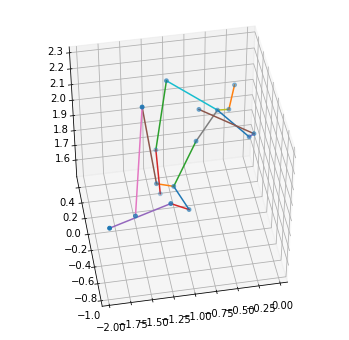

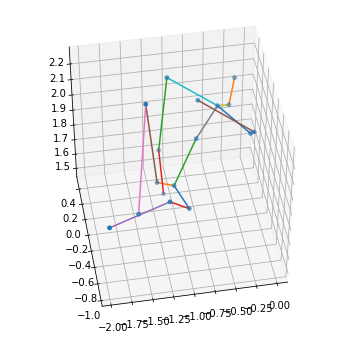

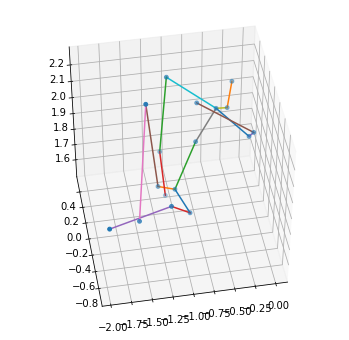

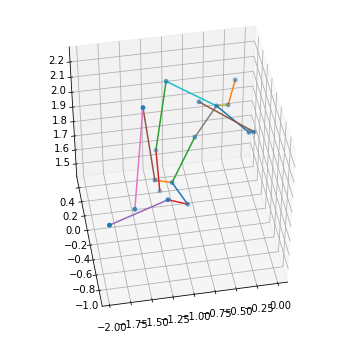

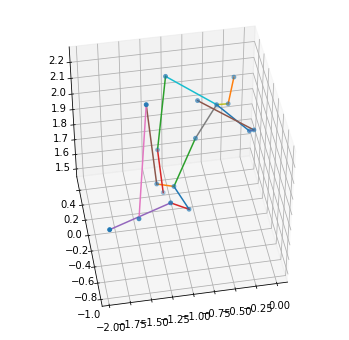

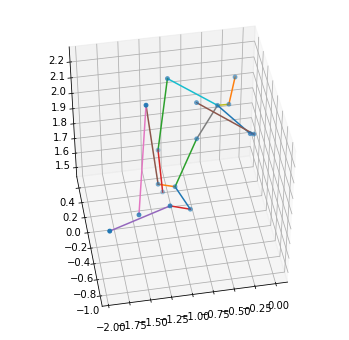

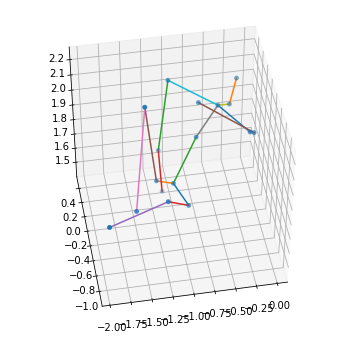

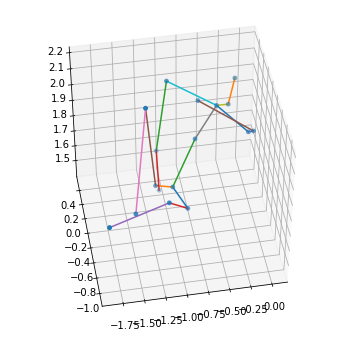

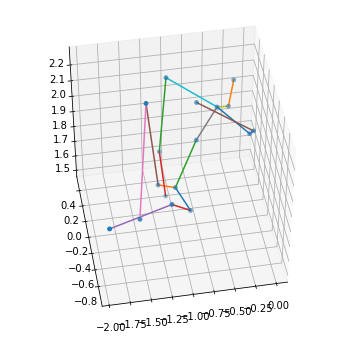

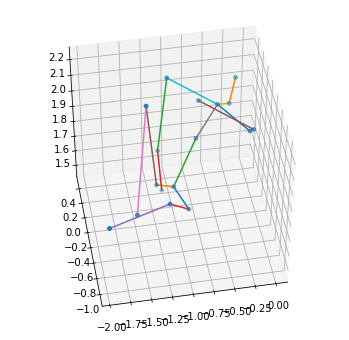

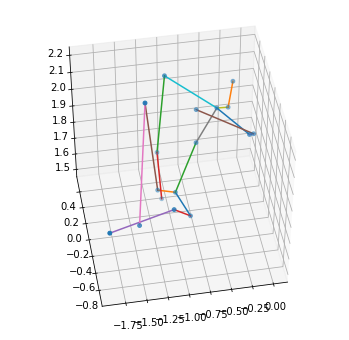

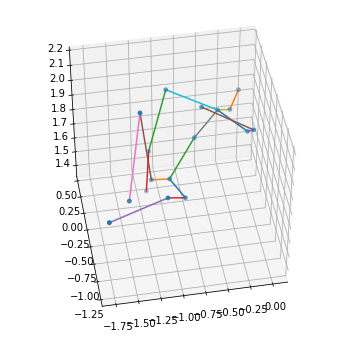

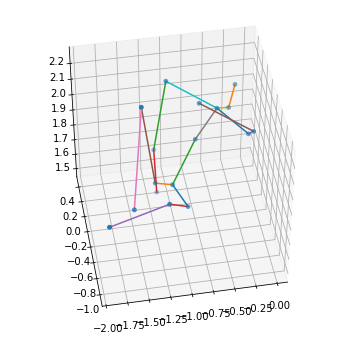

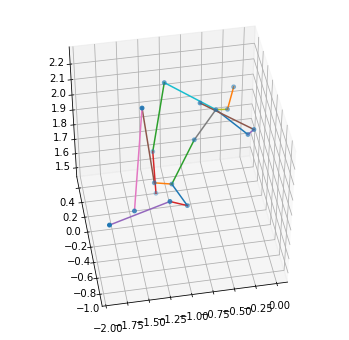

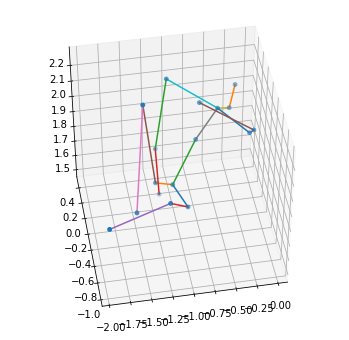

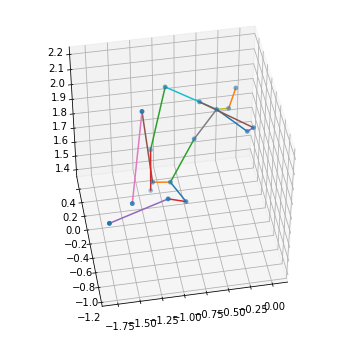

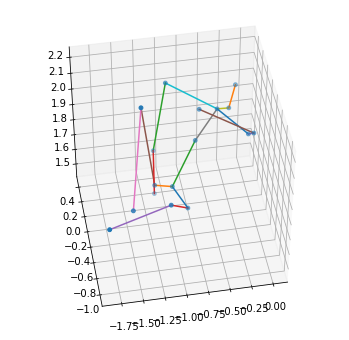

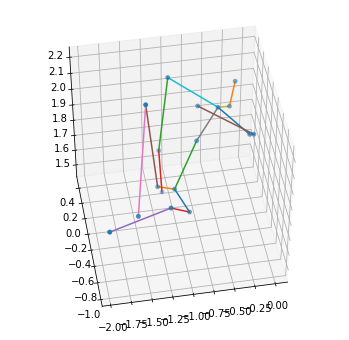

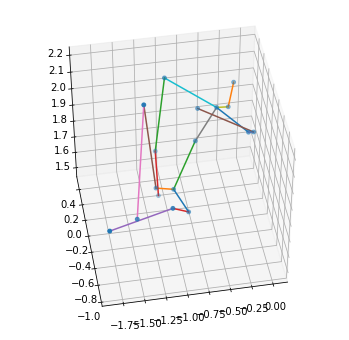

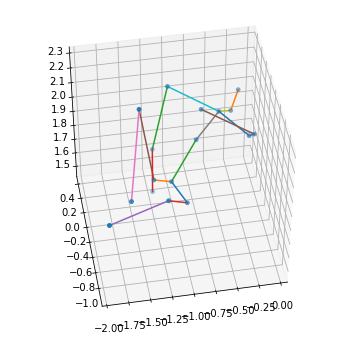

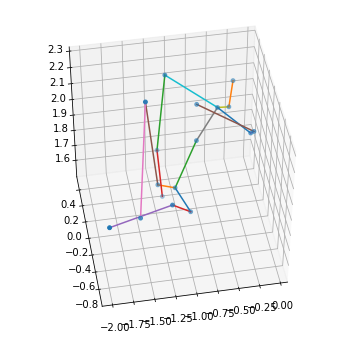

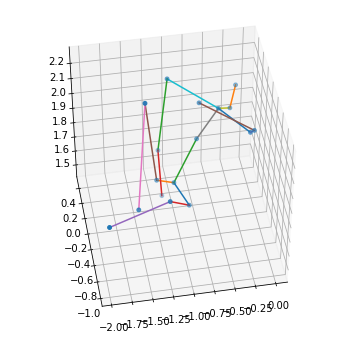

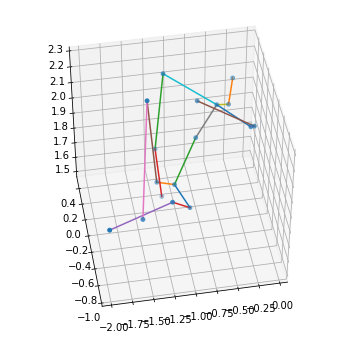

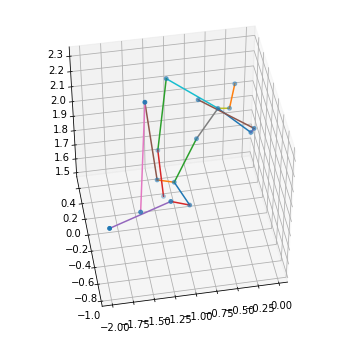

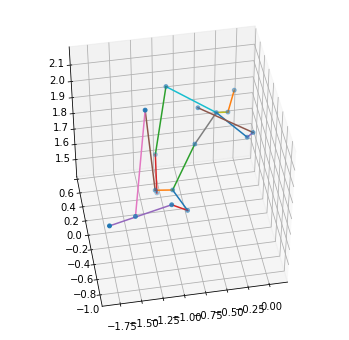

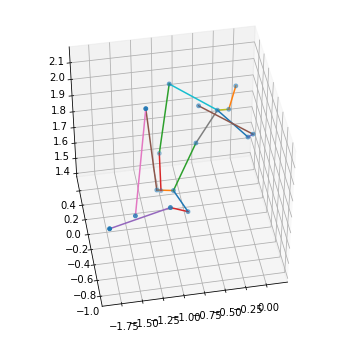

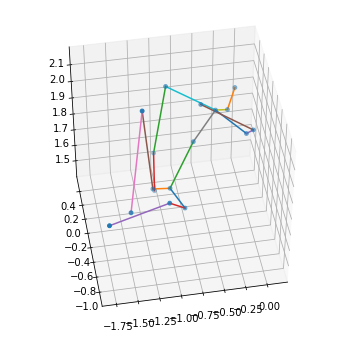

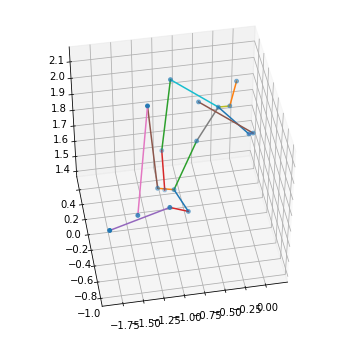

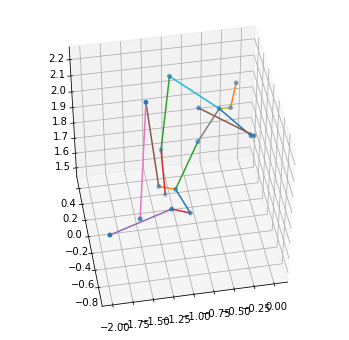

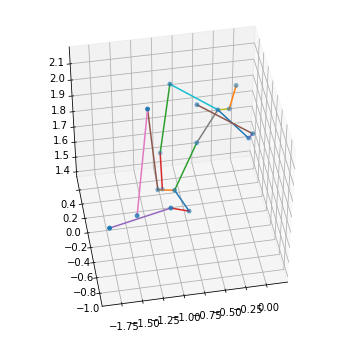

In [ ]:
vision_3d(b4)

## 추가 데이터 전처리 

In [ ]:
def making_pose_input(df):
  final_input=[]
  if ((df.iloc[8][0]!= None) & (df.iloc[8][1]!=None))&((df.iloc[11][0] != None) & (df.iloc[11][1] != None)):
    hip=((df.iloc[8][0]+df.iloc[11][0])/2,(df.iloc[8][1]+df.iloc[11][1])/2)
    final_input.append(np.float32(hip))
  else:
    final_input.append((np.nan,np.nan))
  right_hip=df.iloc[8]
  final_input.append(np.float32(right_hip))
  right_knee=df.iloc[9]
  final_input.append(np.float32(right_knee))
  right_foot=df.iloc[10]
  final_input.append(np.float32(right_foot))
  left_hip=df.iloc[11]
  final_input.append(np.float32(left_hip))
  left_knee=df.iloc[12]
  final_input.append(np.float32(left_knee))
  left_foot=df.iloc[13]
  final_input.append(np.float32(left_foot))
  spine=df.iloc[1]
  final_input.append(np.float32(spine))
  if ((df.iloc[1][0] != None)&(df.iloc[1][1] != None))&((df.iloc[0][0] != None)&(df.iloc[0][1] != None)):
    thorax=(df.iloc[1][0]*2-(df.iloc[0][0]+df.iloc[1][0])/2,df.iloc[1][1]*2-(df.iloc[0][1]+df.iloc[1][1])/2)
    final_input.append(np.float32(thorax))
  else:
    final_input.append((np.nan,np.nan))
  head=df.iloc[0]
  final_input.append(np.float32(head))
  left_shoulder=df.iloc[5]
  final_input.append(np.float32(left_shoulder))
  left_elbow=df.iloc[6]
  final_input.append(np.float32(left_elbow))
  left_wrist=df.iloc[7]
  final_input.append(np.float32(left_wrist))
  right_shoulder=df.iloc[2]
  final_input.append(np.float32(right_shoulder))
  right_elbow=df.iloc[3]
  final_input.append(np.float32(right_elbow))
  right_wrist=df.iloc[4]
  final_input.append(np.float32(right_wrist))
  return final_input

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/my_model')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/my_model')
# 모델의 입력
# 나중에 사용할 수도 있는 label 열도 일단은 생성.
def data2d_import(path):
  # 이미지 읽어오기
  image = cv2.imread(path,cv2.IMREAD_COLOR)
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image2 = cv2.resize(image, dsize=(368, 368), interpolation=cv2.INTER_AREA)
  image3=np.transpose(np.float32(image2[:,:,:,np.newaxis]), (3,0,1,2))
  return image3

def data_to_skeleton(image):
  output=new_model.predict(image)
  H = output[11].shape[1]
  W = output[11].shape[2]
  conf=output[11]
  imageHeight, imageWidth, _ = (368,368,3)
  points = []
  for i in range(0,18):
      # 해당 신체부위 신뢰도 얻음.
      probMap = conf[0, :, :, i]
  
      # global 최대값 찾기
      minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

      # 원래 이미지에 맞게 점 위치 변경
      x = (imageWidth * point[0]) / W
      y = (imageHeight * point[1]) / H     
      points.append((int(x), int(y)))
  return points

def data_to_input(data):
  temp=pd.DataFrame(columns=['x','y'])
  x_list=[]
  y_list=[]
  for i in data:
      x_list.append(i[0])
      y_list.append(i[1])
  temp['x']=x_list
  temp['y']=y_list
  list_temp=making_pose_input(temp)
  a=pd.DataFrame(list_temp,columns=['x','y'])
  return a

In [ ]:
# 입력 데이터 전처리 함수
def input_making(path):
  image=data2d_import(path)
  points=data_to_skeleton(image)
  result=data_to_input(points)
  return result 

In [ ]:
main_path="/content/drive/MyDrive/cv_data/"
for i in os.listdir(main_path):
  sub_path1=main_path+i+'/'
  for j in os.listdir(sub_path1):
    if int(j[2:4])==53:
      print(j)

In [ ]:
def video2photo(path,filepath):
  video = cv2.VideoCapture(filepath)
  count = 0
  try:
    os.mkdir("/content/drive/MyDrive/cv_data/A053/"+path)
  except:
    print("이미 생성된 파일입니다.\n")

  write_path="/content/drive/MyDrive/cv_data/A053/"+path+"/"
  while (video.isOpened()):
      # read()는 grab()와 retrieve() 두 함수를 한 함수로 불러옴
      # 두 함수를 동시에 불러오는 이유는 프레임이 존재하지 않을 때
      # grab() 함수를 이용하여 return false 혹은 NULL 값을 넘겨 주기 때문
      ret, image = video.read()
      if ret != True: 
        break
      if (int(video.get(cv2.CAP_PROP_FRAME_COUNT)<=30)):
        os.rmdir("/content/drive/MyDrive/cv_data/A053/"+path)                  
        return filepath
        break;
      if (int(video.get(1)) % int(video.get(cv2.CAP_PROP_FRAME_COUNT)/30) == 0):
          #print('Saved frame number : ' + str(int(video.get(1))))
          cv2.imwrite(write_path+"%d.jpg" % count, image)
          #print('Saved frame%d.jpg' % count)
          count += 1
      if count==30:
        video.release()
        break
  video.release()

In [ ]:
os.mkdir("/content/drive/MyDrive/cv_data/A053")
for subpath in os.listdir("/content/drive/MyDrive/RGB(51-100)/"):
  for path in os.listdir("/content/drive/MyDrive/RGB(51-100)/"+subpath):
    path_parse=path.split(".")[0]
    path_="/content/drive/MyDrive/RGB(51-100)/"+subpath+"/"+path
    video2photo(path_parse,path_)

In [ ]:
main_path="/content/drive/MyDrive/cv_data/A053/"

In [ ]:
os.listdir(main_path)

['A053_P051_G001_C001',
 'A053_P051_G001_C002',
 'A053_P051_G001_C003',
 'A053_P051_G001_C004',
 'A053_P051_G001_C005',
 'A053_P051_G001_C006',
 'A053_P051_G001_C007',
 'A053_P051_G001_C008',
 'A053_P051_G002_C001',
 'A053_P051_G002_C002',
 'A053_P051_G002_C003',
 'A053_P051_G002_C004',
 'A053_P051_G002_C005',
 'A053_P051_G002_C006',
 'A053_P051_G002_C007',
 'A053_P051_G002_C008',
 'A053_P051_G003_C001',
 'A053_P051_G003_C002',
 'A053_P051_G003_C003',
 'A053_P051_G003_C004',
 'A053_P051_G003_C005',
 'A053_P051_G003_C006',
 'A053_P051_G003_C007',
 'A053_P051_G003_C008',
 'A053_P051_G004_C001',
 'A053_P051_G004_C002',
 'A053_P051_G004_C003',
 'A053_P051_G004_C004',
 'A053_P051_G004_C005',
 'A053_P051_G004_C006',
 'A053_P051_G004_C007',
 'A053_P051_G004_C008',
 'A053_P051_G005_C001',
 'A053_P051_G005_C002',
 'A053_P051_G005_C003',
 'A053_P051_G005_C004',
 'A053_P051_G005_C005',
 'A053_P051_G005_C006',
 'A053_P051_G005_C007',
 'A053_P051_G005_C008',
 'A053_P052_G001_C001',
 'A053_P052_G001

In [ ]:
for i in os.listdir(main_path)[:5]:
  print(i)
  sub_path1=main_path+i+'/'
  for j in os.listdir(sub_path1):
    print(j)    

A053_P051_G001_C001
0.jpg
1.jpg
2.jpg
3.jpg
4.jpg
5.jpg
6.jpg
7.jpg
8.jpg
9.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
16.jpg
17.jpg
18.jpg
19.jpg
20.jpg
21.jpg
22.jpg
23.jpg
24.jpg
25.jpg
26.jpg
27.jpg
28.jpg
29.jpg
A053_P051_G001_C002
0.jpg
1.jpg
2.jpg
3.jpg
4.jpg
5.jpg
6.jpg
7.jpg
8.jpg
9.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
16.jpg
17.jpg
18.jpg
19.jpg
20.jpg
21.jpg
22.jpg
23.jpg
24.jpg
25.jpg
26.jpg
27.jpg
28.jpg
29.jpg
A053_P051_G001_C003
0.jpg
1.jpg
2.jpg
3.jpg
4.jpg
5.jpg
6.jpg
7.jpg
8.jpg
9.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
16.jpg
17.jpg
18.jpg
19.jpg
20.jpg
21.jpg
22.jpg
23.jpg
24.jpg
25.jpg
26.jpg
27.jpg
28.jpg
29.jpg
A053_P051_G001_C004
0.jpg
1.jpg
2.jpg
3.jpg
4.jpg
5.jpg
6.jpg
7.jpg
8.jpg
9.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
16.jpg
17.jpg
18.jpg
19.jpg
20.jpg
21.jpg
22.jpg
23.jpg
24.jpg
25.jpg
26.jpg
27.jpg
28.jpg
29.jpg
A053_P051_G001_C005
0.jpg
1.jpg
2.jpg
3.jpg
4.jpg
5.jpg
6.jpg
7.jpg
8.jpg
9.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jp

In [ ]:
main_path="/content/drive/MyDrive/cv_data/A053/"
for i in os.listdir(main_path):
  sub_path1=main_path+i+'/'
  if i in os.listdir("/content/drive/MyDrive/2d_skeleton/A0532/"):
      print("이미 처리한 파일입니다.")
      continue 
  temp=pd.DataFrame(columns=['x','y'])
  for j in os.listdir(sub_path1):
    filepath=sub_path1+j
    print(filepath)
    x_temp = input_making(filepath)
    temp=pd.concat([temp,x_temp],axis=0)
  write_path="/content/drive/MyDrive/2d_skeleton/A0532/"+i
  try:
    os.mkdir(write_path)
    temp.to_csv(write_path+'/'+i+'.csv',index=False)
  except:
    print("이미 생성된 폴더입니다.\n")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/10.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/11.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/12.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/13.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/14.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/15.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/16.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/17.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/18.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/19.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/20.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/21.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/22.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/23.jpg
/content/drive/MyDrive/cv_data/A053/A053_P095_G004_C002/24.jpg
/content/drive/MyDr

3d Pose baseline 입력 -> 기존 데이터 합병 -> stgcn 재학습 task 남음

In [ ]:
path="./drive/MyDrive/2d_skeleton/"
os.listdir(path+"A0532")

['A053_P069_G003_C008',
 'A053_P069_G004_C001',
 'A053_P069_G004_C002',
 'A053_P069_G004_C003',
 'A053_P069_G004_C004',
 'A053_P069_G004_C005',
 'A053_P069_G004_C006',
 'A053_P069_G004_C007',
 'A053_P069_G004_C008',
 'A053_P070_G001_C001',
 'A053_P070_G001_C002',
 'A053_P070_G001_C003',
 'A053_P070_G001_C004',
 'A053_P070_G001_C005',
 'A053_P070_G001_C006',
 'A053_P070_G001_C007',
 'A053_P070_G001_C008',
 'A053_P070_G002_C001',
 'A053_P070_G002_C002',
 'A053_P070_G002_C003',
 'A053_P070_G002_C004',
 'A053_P070_G002_C005',
 'A053_P070_G002_C006',
 'A053_P070_G002_C007',
 'A053_P070_G002_C008',
 'A053_P070_G003_C001',
 'A053_P070_G003_C002',
 'A053_P070_G003_C003',
 'A053_P070_G003_C004',
 'A053_P070_G003_C005',
 'A053_P070_G003_C006',
 'A053_P070_G003_C007',
 'A053_P070_G003_C008',
 'A053_P070_G004_C001',
 'A053_P070_G004_C002',
 'A053_P070_G004_C003',
 'A053_P070_G004_C004',
 'A053_P070_G004_C005',
 'A053_P070_G004_C006',
 'A053_P070_G004_C007',
 'A053_P070_G004_C008',
 'A053_P071_G001

In [ ]:
def fetch_x_y_data(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"A0532f/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/A0532f/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
xplus,yplus=fetch_x_y_data(path)

In [ ]:
xplus.shape

(50340, 16, 2)

In [ ]:
np.array(yplus).shape

(1678,)

In [ ]:
yplus2=np.array(yplus)

In [ ]:
xplus2=xplus.reshape(1678,30,16,2)

In [ ]:
xplus2.shape

(1678, 30, 16, 2)

In [ ]:
test3=np.load("./drive/MyDrive/data_extract/xyuseadd.npz")

In [ ]:
x_re=test3['x']
y_re=test3['y']
x_re.shape
y_re.shape

(5654,)

In [ ]:
xall=np.concatenate([x_re,xplus2],axis=0)
yall=np.concatenate([y_re,yplus2],axis=0)

In [ ]:
xall.shape

(7332, 30, 16, 2)

In [ ]:
yall.shape

(7332,)

In [ ]:
for i,value in enumerate(yall):
  if(value==52):
    yall[i]=44
  if(value==53):
    yall[i]=45
  if(value==54):
    yall[i]=46
  if(value==55):
    yall[i]=47
for i,value in enumerate(yall):
  if(value==45):
    yall[i]=1
  else:
    yall[i]=0

In [ ]:
np.unique(yall)

array([0, 1])

In [ ]:
xall.shape

(7332, 30, 16, 2)

In [ ]:
xall3dinput=xall.reshape(7332*30,16,2)

In [ ]:
my3d=keras.models.load_model("./drive/MyDrive/save_model/3dpose")
x_3d=my3d.predict(xall3dinput)
x_3d.shape

(219960, 51)

In [ ]:
x=x_3d.reshape(7332*30,17,3)
x=x.reshape(7332,30,17,3)
x.shape

(7332, 30, 17, 3)

In [ ]:
yall.shape

(7332,)

In [ ]:
np.savez("./drive/MyDrive/data_extract/xyall.npz",x=x,y=yall)

In [ ]:
stgcn=mystgcn()
y=tf.one_hot(yall,depth=2)
y_1=np.array(y)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y_1,test_size=0.2, random_state=42,stratify=y_1)

In [ ]:
x_train2=tf.stack(x_train)
x_train3=tf.transpose(x_train2,perm=[0,3,1,2])
x_test2=tf.stack(x_test)
x_test3=tf.transpose(x_test2,perm=[0,3,1,2])
y_train2=tf.stack(y_train)
y_test2=tf.stack(y_test)

In [ ]:
early_cb=keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True)
opt= tf.keras.optimizers.Adam()
myloss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
stgcn.compile(loss=myloss,optimizer=opt)

In [ ]:
history2=stgcn.fit(x_train3,y_train2,epochs=10000,validation_data=(x_test3,y_test2),callbacks=[early_cb])

Epoch 1/10000
184/184 [==============================] - 35s 106ms/step - loss: 1.9874 - val_loss: 1.1948
Epoch 2/10000
184/184 [==============================] - 18s 98ms/step - loss: 0.8975 - val_loss: 0.8628
Epoch 3/10000
184/184 [==============================] - 18s 97ms/step - loss: 0.7786 - val_loss: 0.8336
Epoch 4/10000
184/184 [==============================] - 17s 95ms/step - loss: 0.7638 - val_loss: 0.7309
Epoch 5/10000
184/184 [==============================] - 18s 95ms/step - loss: 0.7306 - val_loss: 0.6721
Epoch 6/10000
184/184 [==============================] - 17s 95ms/step - loss: 0.7016 - val_loss: 0.7571
Epoch 7/10000
184/184 [==============================] - 18s 95ms/step - loss: 0.6717 - val_loss: 0.6458
Epoch 8/10000
184/184 [==============================] - 18s 96ms/step - loss: 0.6409 - val_loss: 0.6948
Epoch 9/10000
184/184 [==============================] - 17s 94ms/step - loss: 0.6064 - val_loss: 0.5824
Epoch 10/10000
184/184 [==============================

In [ ]:
stgcn.save("./drive/MyDrive/save_model/stgcnrevision0523")

ytrain_pred=stgcn.predict(x_train3)
ytest_pred=stgcn.predict(x_test3)

INFO:tensorflow:Assets written to: ./drive/MyDrive/save_model/stgcnrevision0523/assets


In [ ]:
ytrlabel=np.argmax(ytrain_pred,axis=1)
yttlabel=np.argmax(ytest_pred,axis=1)

realtrain=np.argmax(np.array(y_train2),axis=1)
realtest=np.argmax(np.array(y_test2),axis=1)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('테스트 예측 정확도: {0:.4f} \n test 오분류표 \n'.format(accuracy_score(yttlabel, realtest)))
print(confusion_matrix(yttlabel,realtest))
print('트레인 예측 정확도: {0:.4f} \n train 오분류표 \n'.format(accuracy_score(ytrlabel, realtrain)))
print(confusion_matrix(ytrlabel,realtrain))

테스트 예측 정확도: 0.9836 
 test 오분류표 

[[863  16]
 [  8 580]]
트레인 예측 정확도: 0.9985 
 train 오분류표 

[[3484    9]
 [   0 2372]]


In [ ]:
saved_model_dir2="./drive/MyDrive/save_model/stgcnrevision0523"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quantized_model = converter.convert()
open("./drive/MyDrive/tflite/mystgcn0523.tflite", "wb").write(tflite_quantized_model)

16617072

## 데이터 증강

In [ ]:
def making_pose_input(df):
  final_input=[]
  if ((df.iloc[8][0]!= None) & (df.iloc[8][1]!=None))&((df.iloc[11][0] != None) & (df.iloc[11][1] != None)):
    hip=((df.iloc[8][0]+df.iloc[11][0])/2,(df.iloc[8][1]+df.iloc[11][1])/2)
    final_input.append(np.float32(hip))
  else:
    final_input.append((np.nan,np.nan))
  right_hip=df.iloc[8]
  final_input.append(np.float32(right_hip))
  right_knee=df.iloc[9]
  final_input.append(np.float32(right_knee))
  right_foot=df.iloc[10]
  final_input.append(np.float32(right_foot))
  left_hip=df.iloc[11]
  final_input.append(np.float32(left_hip))
  left_knee=df.iloc[12]
  final_input.append(np.float32(left_knee))
  left_foot=df.iloc[13]
  final_input.append(np.float32(left_foot))
  spine=df.iloc[1]
  final_input.append(np.float32(spine))
  if ((df.iloc[1][0] != None)&(df.iloc[1][1] != None))&((df.iloc[0][0] != None)&(df.iloc[0][1] != None)):
    thorax=(df.iloc[1][0]*2-(df.iloc[0][0]+df.iloc[1][0])/2,df.iloc[1][1]*2-(df.iloc[0][1]+df.iloc[1][1])/2)
    final_input.append(np.float32(thorax))
  else:
    final_input.append((np.nan,np.nan))
  head=df.iloc[0]
  final_input.append(np.float32(head))
  left_shoulder=df.iloc[5]
  final_input.append(np.float32(left_shoulder))
  left_elbow=df.iloc[6]
  final_input.append(np.float32(left_elbow))
  left_wrist=df.iloc[7]
  final_input.append(np.float32(left_wrist))
  right_shoulder=df.iloc[2]
  final_input.append(np.float32(right_shoulder))
  right_elbow=df.iloc[3]
  final_input.append(np.float32(right_elbow))
  right_wrist=df.iloc[4]
  final_input.append(np.float32(right_wrist))
  return final_input

Flip을 통한 데이터 증강

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/my_model')
# 모델의 입력
# 나중에 사용할 수도 있는 label 열도 일단은 생성.
def data2d_import(path):
  # 이미지 읽어오기
  image = cv2.imread(path,cv2.IMREAD_COLOR)
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.flip(image, 1)
  image2 = cv2.resize(image, dsize=(368, 368), interpolation=cv2.INTER_AREA)
  image3=np.transpose(np.float32(image2[:,:,:,np.newaxis]), (3,0,1,2))
  return image3

def data_to_skeleton(image):
  output=new_model.predict(image)
  H = output[11].shape[1]
  W = output[11].shape[2]
  conf=output[11]
  imageHeight, imageWidth, _ = (368,368,3)
  points = []
  for i in range(0,18):
      # 해당 신체부위 신뢰도 얻음.
      probMap = conf[0, :, :, i]
  
      # global 최대값 찾기
      minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

      # 원래 이미지에 맞게 점 위치 변경
      x = (imageWidth * point[0]) / W
      y = (imageHeight * point[1]) / H     
      points.append((int(x), int(y)))
  return points

def data_to_input(data):
  temp=pd.DataFrame(columns=['x','y'])
  x_list=[]
  y_list=[]
  for i in data:
      x_list.append(i[0])
      y_list.append(i[1])
  temp['x']=x_list
  temp['y']=y_list
  list_temp=making_pose_input(temp)
  a=pd.DataFrame(list_temp,columns=['x','y'])
  return a

In [ ]:
# 입력 데이터 전처리 함수
def input_making(path):
  image=data2d_import(path)
  points=data_to_skeleton(image)
  result=data_to_input(points)
  return result 

In [ ]:
main_path="/content/drive/MyDrive/cv_data/A053/"
for i in os.listdir(main_path):
  sub_path1=main_path+i+'/'
  if i in os.listdir("/content/drive/MyDrive/2d_skeleton/A0532f/"):
      print("이미 처리한 파일입니다.")
      continue 
  temp=pd.DataFrame(columns=['x','y'])
  for j in os.listdir(sub_path1):
    filepath=sub_path1+j
    print(filepath)
    x_temp = input_making(filepath)
    temp=pd.concat([temp,x_temp],axis=0)
  write_path="/content/drive/MyDrive/2d_skeleton/A0532f/"+i
  try:
    os.mkdir(write_path)
    temp.to_csv(write_path+'/'+i+'.csv',index=False)
  except:
    print("이미 생성된 폴더입니다.\n")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/10.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/11.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/12.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/13.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/14.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/15.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/16.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/17.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/18.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/19.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/20.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/21.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/22.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/23.jpg
/content/drive/MyDrive/cv_data/A053/A053_P064_G003_C001/24.jpg
/content/drive/MyDr

In [ ]:
def fetch_x_y_data(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"A0532f/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/A0532f/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
my3d=keras.models.load_model("./drive/MyDrive/save_model/3dpose")

In [ ]:
path="./drive/MyDrive/2d_skeleton/"

In [ ]:
test3=np.load("./drive/MyDrive/data_extract/xyall.npz")

In [ ]:
x_re=test3['x']
y_re=test3['y']
x_re.shape
y_re.shape

(7332,)

In [ ]:
x_re.shape

(7332, 30, 17, 3)

In [ ]:
xf,yf=fetch_x_y_data(path)

In [ ]:
yplus2=np.array(yf)
yplus2.shape

(1678,)

In [ ]:
xf.shape

(50340, 16, 2)

In [ ]:
x_3d=my3d.predict(xf)
x_3d.shape

(50340, 51)

In [ ]:
xplus2=x_3d.reshape(1678,30,17,3)

In [ ]:
for i,value in enumerate(yplus2):
  if(value==52):
    yplus2[i]=44
  if(value==53):
    yplus2[i]=45
  if(value==54):
    yplus2[i]=46
  if(value==55):
    yplus2[i]=47
for i,value in enumerate(yplus2):
  if(value==45):
    yplus2[i]=1
  else:
    yplus2[i]=0

In [ ]:
np.unique(yplus2)

array([1])

In [ ]:
xall=np.concatenate([x_re,xplus2],axis=0)
yall=np.concatenate([y_re,yplus2],axis=0)

In [ ]:
xall.shape

(9010, 30, 17, 3)

In [ ]:
yall.shape

(9010,)

In [ ]:
np.savez("./drive/MyDrive/data_extract/xyflipall.npz",x=xall,y=yall)

In [ ]:
stgcn=mystgcn()
y=tf.one_hot(yall,depth=2)
y_1=np.array(y)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xall,y_1,test_size=0.2, random_state=42,stratify=y_1)

x_train2=tf.stack(x_train)
x_train3=tf.transpose(x_train2,perm=[0,3,1,2])
x_test2=tf.stack(x_test)
x_test3=tf.transpose(x_test2,perm=[0,3,1,2])
y_train2=tf.stack(y_train)
y_test2=tf.stack(y_test)

early_cb=keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True)
opt= tf.keras.optimizers.Adam()
myloss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
stgcn.compile(loss=myloss,optimizer=opt)

In [ ]:
x_train3.shape

TensorShape([7208, 3, 30, 17])

In [ ]:
y_train2.shape

TensorShape([7208, 2])

In [ ]:
x_test3.shape

TensorShape([1802, 3, 30, 17])

In [ ]:
history=stgcn.fit(x_train3,y_train2,epochs=10000,validation_data=(x_test3,y_test2),callbacks=[early_cb])

Epoch 1/10000
226/226 [==============================] - 38s 102ms/step - loss: 1.6079 - val_loss: 0.8934
Epoch 2/10000
226/226 [==============================] - 21s 93ms/step - loss: 0.8551 - val_loss: 0.7994
Epoch 3/10000
226/226 [==============================] - 21s 91ms/step - loss: 0.7791 - val_loss: 0.7177
Epoch 4/10000
226/226 [==============================] - 20s 91ms/step - loss: 0.7282 - val_loss: 0.6444
Epoch 5/10000
226/226 [==============================] - 21s 91ms/step - loss: 0.6927 - val_loss: 0.6019
Epoch 6/10000
226/226 [==============================] - 21s 91ms/step - loss: 0.6344 - val_loss: 0.6223
Epoch 7/10000
226/226 [==============================] - 21s 91ms/step - loss: 0.5981 - val_loss: 0.5490
Epoch 8/10000
226/226 [==============================] - 20s 91ms/step - loss: 0.5822 - val_loss: 0.6624
Epoch 9/10000
226/226 [==============================] - 21s 91ms/step - loss: 0.5390 - val_loss: 0.4866
Epoch 10/10000
226/226 [==============================

In [ ]:
stgcn.save("./drive/MyDrive/save_model/stgcnrevision0526")

ytrain_pred=stgcn.predict(x_train3)
ytest_pred=stgcn.predict(x_test3)

ytrlabel=np.argmax(ytrain_pred,axis=1)
yttlabel=np.argmax(ytest_pred,axis=1)

realtrain=np.argmax(np.array(y_train2),axis=1)
realtest=np.argmax(np.array(y_test2),axis=1)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('테스트 예측 정확도: {0:.4f} \n test 오분류표 \n'.format(accuracy_score(yttlabel, realtest)))
print(confusion_matrix(yttlabel,realtest))
print('트레인 예측 정확도: {0:.4f} \n train 오분류표 \n'.format(accuracy_score(ytrlabel, realtrain)))
print(confusion_matrix(ytrlabel,realtrain))

INFO:tensorflow:Assets written to: ./drive/MyDrive/save_model/stgcnrevision0526/assets
테스트 예측 정확도: 0.9906 
 test 오분류표 

[[860   6]
 [ 11 925]]
트레인 예측 정확도: 0.9974 
 train 오분류표 

[[3478   13]
 [   6 3711]]


In [ ]:
saved_model_dir2="./drive/MyDrive/save_model/stgcnrevision0526"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quantized_model = converter.convert()
open("./drive/MyDrive/tflite/mystgcn0526.tflite", "wb").write(tflite_quantized_model)

16619488

## 추가 6,7,8,9 사람

이전에 개발 기간의 제약으로 추가적인 데이터 전처리 작업을 하지못함

추가적으로 데이터를 가져와 학습 데이터로 사용

In [ ]:
def fetch_x_y_data6(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P006/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P006/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data7(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P007/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P007/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data8(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P008/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P008/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data9(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P009/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P009/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
path="./drive/MyDrive/2d_skeleton/"

In [ ]:
path="./drive/MyDrive/2d_skeleton/"
x6,y6=fetch_x_y_data6(path)
x7,y7=fetch_x_y_data7(path)
x8,y8=fetch_x_y_data8(path)
x9,y9=fetch_x_y_data9(path)

In [ ]:
my3d=keras.models.load_model("./drive/MyDrive/save_model/3dpose")

In [ ]:
test3=np.load("./drive/MyDrive/data_extract/xyflipall.npz")

In [ ]:
print(x6.shape,len(y6),x7.shape,len(y7),x8.shape,len(y8),x9.shape,len(y9))

(31680, 16, 2) 1056 (27840, 16, 2) 928 (27600, 16, 2) 920 (27840, 16, 2) 928


In [ ]:
test3=np.load("./drive/MyDrive/data_extract/xyflipall.npz")
x=test3['x']
y=test3['y']

In [ ]:
print(x.shape,y.shape)

(9010, 30, 17, 3) (9010,)


In [ ]:
xplus=np.concatenate([x6,x7,x8,x9],axis=0)

In [ ]:
xplus.shape

(114960, 16, 2)

In [ ]:
y6=np.array(y6)
y7=np.array(y7)
y8=np.array(y8)
y9=np.array(y9)

In [ ]:
y6.shape

(1056,)

In [ ]:
yplus=np.concatenate([y6,y7,y8,y9],axis=0)

In [ ]:
yplus.shape

(3832,)

In [ ]:
xplus2=my3d(xplus)

In [ ]:
xplus2.shape

TensorShape([114960, 51])

In [ ]:
xplus3=np.array(xplus2)

In [ ]:
xplus4=xplus3.reshape(3832,30,17,3)

In [ ]:
xplus4.shape

(3832, 30, 17, 3)

In [ ]:
np.unique(yplus)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 54, 55])

In [ ]:
xplus4.shape

(3832, 30, 17, 3)

In [ ]:
yplus2=pd.Series(yplus)

In [ ]:
yplus2

0       12
1       12
2       12
3       12
4       12
        ..
3827     7
3828     7
3829     7
3830     7
3831     7
Length: 3832, dtype: int64

In [ ]:
uindex=np.array(yplus2[yplus2.isin([44,45,46,47,48,49,50,51])==False].index)

In [ ]:
yplus3=yplus[uindex]

In [ ]:
xplus5=xplus4[uindex]

In [ ]:
yplus3.shape

(3712,)

In [ ]:
xplus5.shape

(3712, 30, 17, 3)

In [ ]:
np.unique(yplus3)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 52, 54, 55])

In [ ]:
y_re=yplus3

In [ ]:
for i,value in enumerate(y_re):
  if(value==52):
    y_re[i]=44
  if(value==53):
    y_re[i]=45
  if(value==54):
    y_re[i]=46
  if(value==55):
    y_re[i]=47
for i,value in enumerate(y_re):
  if(value==45):
    y_re[i]=1
  else:
    y_re[i]=0  

In [ ]:
np.unique(y_re)

array([0])

In [ ]:
xplus5.shape

(3712, 30, 17, 3)

In [ ]:
y_re.shape

(3712,)

In [ ]:
x.shape

(9010, 30, 17, 3)

In [ ]:
y.shape

(9010,)

In [ ]:
xdata=np.concatenate([x,xplus5],axis=0)
ydata=np.concatenate([y,y_re],axis=0)

In [ ]:
xdata.shape,ydata.shape

((12722, 30, 17, 3), (12722,))

In [ ]:
np.savez("./drive/MyDrive/data_extract/xy0530.npz",x=xdata,y=ydata)

In [ ]:
xdata.shape

(12722, 30, 17, 3)

In [ ]:
stgcn=mystgcn()
y=tf.one_hot(ydata,depth=2)
y_1=np.array(y)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xdata,y_1,test_size=0.2, random_state=42,stratify=y_1)

x_train2=tf.stack(x_train)
x_train3=tf.transpose(x_train2,perm=[0,3,1,2])
x_test2=tf.stack(x_test)
x_test3=tf.transpose(x_test2,perm=[0,3,1,2])
y_train2=tf.stack(y_train)
y_test2=tf.stack(y_test)

early_cb=keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True)
opt= tf.keras.optimizers.Adam()
myloss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
stgcn.compile(loss=myloss,optimizer=opt,metrics=['accuracy'])

In [ ]:
x_train3.shape

TensorShape([10177, 3, 30, 17])

In [ ]:
y_train2.shape

TensorShape([10177, 2])

In [ ]:
history=stgcn.fit(x_train3,y_train2,epochs=10000,validation_data=(x_test3,y_test2),callbacks=[early_cb])

Epoch 1/10000
319/319 [==============================] - 35s 97ms/step - loss: 1.5306 - accuracy: 0.8633 - val_loss: 0.8233 - val_accuracy: 0.9100
Epoch 2/10000
319/319 [==============================] - 30s 95ms/step - loss: 0.8046 - accuracy: 0.9261 - val_loss: 0.6981 - val_accuracy: 0.9564
Epoch 3/10000
319/319 [==============================] - 30s 94ms/step - loss: 0.7399 - accuracy: 0.9379 - val_loss: 0.6947 - val_accuracy: 0.9536
Epoch 4/10000
319/319 [==============================] - 30s 93ms/step - loss: 0.7527 - accuracy: 0.9303 - val_loss: 0.7272 - val_accuracy: 0.9250
Epoch 5/10000
319/319 [==============================] - 30s 94ms/step - loss: 0.6875 - accuracy: 0.9401 - val_loss: 0.5796 - val_accuracy: 0.9666
Epoch 6/10000
319/319 [==============================] - 30s 93ms/step - loss: 0.5855 - accuracy: 0.9572 - val_loss: 0.5241 - val_accuracy: 0.9741
Epoch 7/10000
319/319 [==============================] - 30s 93ms/step - loss: 0.5368 - accuracy: 0.9577 - val_loss: 1

In [ ]:
stgcn.save("./drive/MyDrive/save_model/stgcnrevision0530")

INFO:tensorflow:Assets written to: ./drive/MyDrive/save_model/stgcnrevision0530/assets


In [ ]:
ytrain_pred=stgcn.predict(x_train3)
ytest_pred=stgcn.predict(x_test3)

ytrlabel=np.argmax(ytrain_pred,axis=1)
yttlabel=np.argmax(ytest_pred,axis=1)

realtrain=np.argmax(np.array(y_train2),axis=1)
realtest=np.argmax(np.array(y_test2),axis=1)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('테스트 예측 정확도: {0:.4f} \n test 오분류표 \n'.format(accuracy_score(yttlabel, realtest)))
print(confusion_matrix(yttlabel,realtest))
print('트레인 예측 정확도: {0:.4f} \n train 오분류표 \n'.format(accuracy_score(ytrlabel, realtrain)))
print(confusion_matrix(ytrlabel,realtrain))

테스트 예측 정확도: 0.9906 
 test 오분류표 

[[1595    5]
 [  19  926]]
트레인 예측 정확도: 0.9977 
 train 오분류표 

[[6446   16]
 [   7 3708]]


In [ ]:
saved_model_dir2="./drive/MyDrive/save_model/stgcnrevision0530"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quantized_model = converter.convert()
open("./drive/MyDrive/tflite/mystgcn0526.tflite", "wb").write(tflite_quantized_model)

16619488

## 추가 20명 사람분

In [ ]:
def fetch_x_y_data10(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P010/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P010/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data21(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P021/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P021/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data22(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P022/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P022/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data23(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P023/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P023/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data24(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P024/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P024/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data25(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P025/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P025/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data26(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P026/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P026/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data27(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P027/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P027/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data28(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P028/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P028/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data29(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P029/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P029/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_data30(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"P030/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/P030/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
path="./drive/MyDrive/2d_skeleton/"
x10,y10=fetch_x_y_data10(path)
x21,y21=fetch_x_y_data21(path)
x22,y22=fetch_x_y_data22(path)
x23,y23=fetch_x_y_data23(path)
x24,y24=fetch_x_y_data24(path)
x25,y25=fetch_x_y_data25(path)
x26,y26=fetch_x_y_data26(path)
x27,y27=fetch_x_y_data27(path)
x28,y28=fetch_x_y_data28(path)
x29,y29=fetch_x_y_data29(path)
x30,y30=fetch_x_y_data30(path)

In [ ]:
my3d=keras.models.load_model("./drive/MyDrive/save_model/3dpose")

In [ ]:
print(x10.shape,len(y10))

(28080, 16, 2) 936


In [ ]:
xplus=np.concatenate([x10,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30],axis=0)
y10=np.array(y10)
y21=np.array(y21)
y22=np.array(y22)
y23=np.array(y23)
y24=np.array(y24)
y25=np.array(y25)
y26=np.array(y26)
y27=np.array(y27)
y28=np.array(y28)
y29=np.array(y29)
y30=np.array(y30)
yplus=np.concatenate([y10,y21,y22,y23,y24,y25,y26,y27,y28,y29,y30],axis=0)
print(xplus.shape,yplus.shape)

(309480, 16, 2) (10316,)


In [ ]:
xplus2=xplus.reshape(10316,30,16,2)

In [ ]:
np.savez("./drive/MyDrive/data_extract/xyplus10_30.npz",x=xplus2,y=yplus)

In [ ]:
xplus3=my3d(xplus)

In [ ]:
xplus3.shape

TensorShape([309480, 51])

In [ ]:
yplus.shape

(10316,)

In [ ]:
xplus3=np.array(xplus3)
xplus4=xplus3.reshape(10316,30,17,3)

In [ ]:
xplus4.shape

(10316, 30, 17, 3)

In [ ]:
test3=np.load("./drive/MyDrive/data_extract/xy0530.npz")
x=test3['x']
y=test3['y']
x.shape,y.shape

((12722, 30, 17, 3), (12722,))

In [ ]:
np.unique(yplus)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 52, 54, 55])

In [ ]:
np.unique(y)

array([0, 1])

In [ ]:
y_re=yplus

In [ ]:
for i,value in enumerate(y_re):
  if(value==52):
    y_re[i]=44
  if(value==53):
    y_re[i]=45
  if(value==54):
    y_re[i]=46
  if(value==55):
    y_re[i]=47
for i,value in enumerate(y_re):
  if(value==45):
    y_re[i]=1
  else:
    y_re[i]=0  

In [ ]:
np.unique(y_re)

array([0])

In [ ]:
y_re.shape

(10316,)

In [ ]:
xplus20=np.concatenate([x,xplus4],axis=0)
yplus20=np.concatenate([y,y_re],axis=0)

In [ ]:
xplus20.shape, yplus20.shape

((23038, 30, 17, 3), (23038,))

In [ ]:
np.savez("./drive/MyDrive/data_extract/data0604.npz",x=xplus20,y=yplus20)

In [ ]:
test3=np.load("./drive/MyDrive/data_extract/data0604.npz")
xall=test3['x']
yall=test3['y']

In [ ]:
stgcn=mystgcn()
y=tf.one_hot(yall,depth=2)
y_1=np.array(y)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xall,y_1,test_size=0.2, random_state=42,stratify=y_1)

x_train2=tf.stack(x_train)
x_train3=tf.transpose(x_train2,perm=[0,3,1,2])
x_test2=tf.stack(x_test)
x_test3=tf.transpose(x_test2,perm=[0,3,1,2])
y_train2=tf.stack(y_train)
y_test2=tf.stack(y_test)

early_cb=keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True)
opt= tf.keras.optimizers.Adam()
myloss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
stgcn.compile(loss=myloss,optimizer=opt,metrics=['accuracy'])

In [ ]:
x_train3.shape,y_train2.shape

(TensorShape([18430, 3, 30, 17]), TensorShape([18430, 2]))

In [ ]:
history=stgcn.fit(x_train3,y_train2,epochs=10000,validation_data=(x_test3,y_test2),callbacks=[early_cb])

Epoch 1/10000
576/576 [==============================] - 56s 66ms/step - loss: 1.1132 - accuracy: 0.8936 - val_loss: 0.7110 - val_accuracy: 0.9479
Epoch 2/10000
576/576 [==============================] - 37s 63ms/step - loss: 0.7017 - accuracy: 0.9378 - val_loss: 0.5760 - val_accuracy: 0.9657
Epoch 3/10000
576/576 [==============================] - 36s 63ms/step - loss: 0.5821 - accuracy: 0.9532 - val_loss: 0.5111 - val_accuracy: 0.9661
Epoch 4/10000
576/576 [==============================] - 36s 63ms/step - loss: 0.4813 - accuracy: 0.9583 - val_loss: 0.4006 - val_accuracy: 0.9746
Epoch 5/10000
576/576 [==============================] - 36s 63ms/step - loss: 0.3969 - accuracy: 0.9650 - val_loss: 0.3564 - val_accuracy: 0.9674
Epoch 6/10000
576/576 [==============================] - 36s 63ms/step - loss: 0.3483 - accuracy: 0.9616 - val_loss: 0.3529 - val_accuracy: 0.9505
Epoch 7/10000
576/576 [==============================] - 36s 63ms/step - loss: 0.2921 - accuracy: 0.9661 - val_loss: 0

In [ ]:
stgcn.save("./drive/MyDrive/save_model/stgcnrevision0604")

INFO:tensorflow:Assets written to: ./drive/MyDrive/save_model/stgcnrevision0604/assets


In [ ]:
ytrain_pred=stgcn.predict(x_train3)
ytest_pred=stgcn.predict(x_test3)

ytrlabel=np.argmax(ytrain_pred,axis=1)
yttlabel=np.argmax(ytest_pred,axis=1)

realtrain=np.argmax(np.array(y_train2),axis=1)
realtest=np.argmax(np.array(y_test2),axis=1)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('테스트 예측 정확도: {0:.4f} \n test 오분류표 \n'.format(accuracy_score(yttlabel, realtest)))
print(confusion_matrix(yttlabel,realtest))
print('트레인 예측 정확도: {0:.4f} \n train 오분류표 \n'.format(accuracy_score(ytrlabel, realtrain)))
print(confusion_matrix(ytrlabel,realtrain))

테스트 예측 정확도: 0.9863 
 test 오분류표 

[[3649   35]
 [  28  896]]
트레인 예측 정확도: 0.9922 
 train 오분류표 

[[14659    96]
 [   47  3628]]


In [ ]:
saved_model_dir2="./drive/MyDrive/save_model/stgcnrevision0604"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quantized_model = converter.convert()
open("./drive/MyDrive/tflite/mystgcn0604.tflite", "wb").write(tflite_quantized_model)

16617072

## 2d로만 분류

10번 부터 30번까지 2d 데이터

In [ ]:
test3=np.load("./drive/MyDrive/data_extract/xyplus10_30.npz")
x=test3['x']
y=test3['y']
x.shape,y.shape

((10316, 30, 16, 2), (10316,))

In [ ]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 52, 54, 55])

1번 5번 + 53번 행동 (1~50명 분)

In [ ]:
test4=np.load("./drive/MyDrive/data_extract/xyuseadd.npz")
x_re=test4['x']
y_re=test4['y']

In [ ]:
x_re.shape,y_re.shape

((5654, 30, 16, 2), (5654,))

In [ ]:
np.unique(y_re)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 52, 53, 54, 55])

In [ ]:
def fetch_x_y_dataA0532(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"A0532/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/A0532/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
def fetch_x_y_dataA0532f(path):
  xa=np.zeros([1,16,2])
  y=[]

  for i in os.listdir(path+"A0532f/"):
    x=pd.read_csv("./drive/MyDrive/2d_skeleton/A0532f/"+i+'/'+i+'.csv')
    a=np.array(x[0:16]).reshape(1,16,2)
    for j in range(29):
      temp=np.array(x[16*(j+1):16*(j+2)]).reshape(1,16,2)
      a=np.concatenate([a,temp],axis=0)
    #a.shape=(30,16,2) 
    if (not np.isnan(a).any()):
      xa=np.concatenate([xa,a],axis=0)
      y.append(int(i[2:4]))
      
  return xa[1:],y 

In [ ]:
path="./drive/MyDrive/2d_skeleton/"
x0532,y0532=fetch_x_y_dataA0532(path)
x0532f,y0532f=fetch_x_y_dataA0532f(path)

In [ ]:
x0532.shape, x0532f.shape

((50340, 16, 2), (50340, 16, 2))

In [ ]:
y3=np.array(y0532)
y4=np.array(y0532f)

In [ ]:
y4.shape

(1678,)

In [ ]:
x3=x0532.reshape(1678,30,16,2)
x4=x0532f.reshape(1678,30,16,2)

In [ ]:
x2d=np.concatenate([x,x_re,x3,x4],axis=0)
y2d=np.concatenate([y,y_re,y3,y4],axis=0)

In [ ]:
x2d.shape, y2d.shape

((19326, 30, 16, 2), (19326,))

In [ ]:
path="./drive/MyDrive/2d_skeleton/"
x6,y6=fetch_x_y_data6(path)
x7,y7=fetch_x_y_data7(path)
x8,y8=fetch_x_y_data8(path)
x9,y9=fetch_x_y_data9(path)

In [ ]:
y6=np.array(y6)
y7=np.array(y7)
y8=np.array(y8)
y9=np.array(y9)

In [ ]:
y6.shape, y7.shape, y8.shape, y9.shape

((1056,), (928,), (920,), (928,))

In [ ]:
x62=x6.reshape(y6.shape[0],30,16,2)
x72=x7.reshape(y7.shape[0],30,16,2)
x82=x8.reshape(y8.shape[0],30,16,2)
x92=x9.reshape(y9.shape[0],30,16,2)

In [ ]:
x62.shape

(1056, 30, 16, 2)

In [ ]:
x2d2=np.concatenate([x2d,x62,x72,x82,x92],axis=0)
y2d2=np.concatenate([y2d,y6,y7,y8,y9],axis=0)

In [ ]:
x2d2.shape, y2d2.shape

((23158, 30, 16, 2), (23158,))

In [ ]:
np.unique(y2d2)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55])

In [ ]:
y2d3=pd.Series(y2d2)

In [ ]:
uindex=np.array(y2d3[y2d3.isin([44,45,46,47,48,49,50,51])==False].index)

In [ ]:
uindex

array([    0,     1,     2, ..., 23155, 23156, 23157])

In [ ]:
np.unique(y2d2[uindex])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 52, 53, 54, 55])

In [ ]:
y2d4=y2d2[uindex]
x2d4=x2d2[uindex]

In [ ]:
np.savez("./drive/MyDrive/data_extract/data0606.npz",x=x2d4,y=y2d4)

In [ ]:
y_re=y2d4

In [ ]:
for i,value in enumerate(y_re):
  if(value==52):
    y_re[i]=44
  if(value==53):
    y_re[i]=45
  if(value==54):
    y_re[i]=46
  if(value==55):
    y_re[i]=47
for i,value in enumerate(y_re):
  if(value==45):
    y_re[i]=1
  else:
    y_re[i]=0  

In [ ]:
np.unique(y_re)

array([0, 1])

In [ ]:
x2d4.shape

(23038, 30, 16, 2)

In [ ]:
y_re.shape

(23038,)

### STGCN - 2D Version

In [ ]:
class Graph2:
    def __init__(self, labeling_mode='spatial'):
        self.num_node = 16
        self.self_link = [(i, i) for i in range(self.num_node)]
        self.inward_ori_index = [(1, 2), (2,3),(3,7),(4,5),(4,7),(5,6),(7,8),(8,9),(9,10),(9,13),(9,14),(11,12),(12,13),(14,15),(15,16)]
        self.inward = [(i - 1, j - 1) for (i, j) in self.inward_ori_index]
        self.outward = [(j, i) for (i, j) in self.inward]
        self.neighbor = self.inward+self.outward
        self.A = self.get_adjacency_matrix(labeling_mode)

    def edge2mat(self,link, num_node):
        A = np.zeros((num_node, num_node))
        for i, j in link:
            A[j, i] = 1
        return A
    def normalize_digraph(self,A):  
        Dl = np.sum(A, 0)
        h, w = A.shape
        Dn = np.zeros((w, w))
        for i in range(w):
            if Dl[i] > 0:
                Dn[i, i] = Dl[i] ** (-1)
        AD = np.dot(A, Dn)
        return AD

    def get_spatial_graph(self,num_node, self_link, inward, outward):
        I = self.edge2mat(self_link, num_node)
        In = self.normalize_digraph(self.edge2mat(inward, num_node))
        Out = self.normalize_digraph(self.edge2mat(outward, num_node))
        A = np.stack((I, In, Out))
        return A

    def get_adjacency_matrix(self, labeling_mode=None):
        if labeling_mode is None:
            return self.A
        if labeling_mode == 'spatial':
            A = self.get_spatial_graph(self.num_node, self.self_link, self.inward, self.outward)
        else:
            raise ValueError()
        return A

In [ ]:
import tensorflow as tf
import numpy as np

REGULARIZER = tf.keras.regularizers.l2(l=0.0001)
INITIALIZER = tf.keras.initializers.VarianceScaling(scale=2.,
                                                    mode="fan_out",
                                                    distribution="truncated_normal")

In [ ]:
class SGCN(tf.keras.Model):
    def __init__(self, filters, kernel_size=3):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv2D(filters*kernel_size,
                                           kernel_size=3,
                                           padding='same',
                                           kernel_initializer=INITIALIZER,
                                           data_format='channels_first',
                                           kernel_regularizer=REGULARIZER)

    # N, C, T, V
    def call(self, x, A, training):
        x = self.conv(x)

        N = tf.shape(x)[0]
        C = tf.shape(x)[1]
        T = tf.shape(x)[2]
        V = tf.shape(x)[3]

        x = tf.reshape(x, [N, self.kernel_size, C//self.kernel_size, T, V])
        x = tf.einsum('nkctv,kvw->nctw', x, A)
        return x, A

In [ ]:
class STGCN(tf.keras.Model):
    #input x=(N,3,30,17) A = (3,17,17)
    def __init__(self, filters, kernel_size=[9, 3], stride=1, activation='relu',
                 residual=True, downsample=False):
        super().__init__()
        self.sgcn = SGCN(filters, kernel_size=kernel_size[1])

        self.tgcn = tf.keras.Sequential()
        self.tgcn.add(tf.keras.layers.BatchNormalization(axis=1))
        self.tgcn.add(tf.keras.layers.Activation(activation))
        self.tgcn.add(tf.keras.layers.Conv2D(filters,
                                                kernel_size=[kernel_size[0], 1],
                                                strides=[stride, 1],
                                                padding='same',
                                                kernel_initializer=INITIALIZER,
                                                data_format='channels_first',
                                                kernel_regularizer=REGULARIZER))
        self.tgcn.add(tf.keras.layers.BatchNormalization(axis=1))

        self.act = tf.keras.layers.Activation(activation)

        if not residual:
            self.residual = lambda x, training=False: 0
        elif residual and stride == 1 and not downsample:
            self.residual = lambda x, training=False: x
        else:
            self.residual = tf.keras.Sequential()
            self.residual.add(tf.keras.layers.Conv2D(filters,
                                                        kernel_size=[1, 1],
                                                        strides=[stride, 1],
                                                        padding='same',
                                                        kernel_initializer=INITIALIZER,
                                                        data_format='channels_first',
                                                        kernel_regularizer=REGULARIZER))
            self.residual.add(tf.keras.layers.BatchNormalization(axis=1))

    def call(self, x, A, training):
        res = self.residual(x, training=training)
        x, A = self.sgcn(x, A, training=training)
        x = self.tgcn(x, training=training)
        x += res
        x = self.act(x)
        return x, A
class mystgcn(tf.keras.Model,Graph2):
    def __init__(self, num_classes=2):
        super().__init__()
        graph = Graph2()
        self.A = tf.constant(graph.A,
                             dtype=tf.float32,
                             name='adjacency_matrix')

        self.data_bn = tf.keras.layers.BatchNormalization(axis=1)

        self.STGCN_layers = []
        self.STGCN_layers.append(STGCN(64, residual=False))
        self.STGCN_layers.append(STGCN(64))
        self.STGCN_layers.append(STGCN(64))
        self.STGCN_layers.append(STGCN(64))
        self.STGCN_layers.append(STGCN(128, stride=2, downsample=True))
        self.STGCN_layers.append(STGCN(128))
        self.STGCN_layers.append(STGCN(128))
        self.STGCN_layers.append(STGCN(256, stride=2, downsample=True))
        self.STGCN_layers.append(STGCN(256))
        self.STGCN_layers.append(STGCN(256))

        self.pool = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_first')

        self.logits = tf.keras.layers.Conv1D(num_classes,
                                             kernel_size=1,
                                             padding='same',
                                             kernel_initializer=INITIALIZER,
                                             data_format='channels_first',
                                             kernel_regularizer=REGULARIZER)

    def call(self, x, training):
        x=x[:,:,:,:,tf.newaxis]
        N = tf.shape(x)[0]
        C = tf.shape(x)[1]
        T = tf.shape(x)[2]
        V = tf.shape(x)[3]
        M = 1

        x = tf.transpose(x, perm=[0, 4, 3, 1, 2])
        x = tf.reshape(x, [N * M, V * C, T])
        x = self.data_bn(x, training=training)
        x = tf.reshape(x, [N, M, V, C, T])
        x = tf.transpose(x, perm=[0, 1, 3, 4, 2])
        x = tf.reshape(x, [N * M, C, T, V]) #(N,3,30,17) A = (3,17,17)

        A = self.A
        for layer in self.STGCN_layers:
            x, A = layer(x, A, training=training)

        # N*M,C,T,V
        x = self.pool(x)
        x = x[:,:,tf.newaxis]
        x = self.logits(x)
        x = tf.reshape(x, [N, -1])

        return x

In [ ]:
stgcn=mystgcn()
y=tf.one_hot(y_re,depth=2)
y_1=np.array(y)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x2d4,y_1,test_size=0.2, random_state=42,stratify=y_1)

x_train2=tf.stack(x_train)
x_train3=tf.transpose(x_train2,perm=[0,3,1,2])
x_test2=tf.stack(x_test)
x_test3=tf.transpose(x_test2,perm=[0,3,1,2])
y_train2=tf.stack(y_train)
y_test2=tf.stack(y_test)

early_cb=keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True)
opt= tf.keras.optimizers.Adam()
myloss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
stgcn.compile(loss=myloss,optimizer=opt,metrics=['accuracy'])

In [ ]:
x_train3.shape, y_train2.shape

(TensorShape([18430, 2, 30, 16]), TensorShape([18430, 2]))

In [ ]:
history=stgcn.fit(x_train3,y_train2,epochs=10000,validation_data=(x_test3,y_test2),callbacks=[early_cb])

Epoch 1/10000
576/576 [==============================] - 65s 84ms/step - loss: 0.9934 - accuracy: 0.9401 - val_loss: 0.6932 - val_accuracy: 0.9659
Epoch 2/10000
576/576 [==============================] - 46s 79ms/step - loss: 0.6314 - accuracy: 0.9676 - val_loss: 0.6074 - val_accuracy: 0.9616
Epoch 3/10000
576/576 [==============================] - 46s 80ms/step - loss: 0.5427 - accuracy: 0.9677 - val_loss: 0.4589 - val_accuracy: 0.9800
Epoch 4/10000
576/576 [==============================] - 46s 80ms/step - loss: 0.4464 - accuracy: 0.9703 - val_loss: 0.3765 - val_accuracy: 0.9835
Epoch 5/10000
576/576 [==============================] - 46s 80ms/step - loss: 0.3644 - accuracy: 0.9748 - val_loss: 0.3061 - val_accuracy: 0.9831
Epoch 6/10000
576/576 [==============================] - 46s 80ms/step - loss: 0.3001 - accuracy: 0.9775 - val_loss: 0.2594 - val_accuracy: 0.9809
Epoch 7/10000
576/576 [==============================] - 46s 80ms/step - loss: 0.2531 - accuracy: 0.9783 - val_loss: 0

In [ ]:
stgcn.save("./drive/MyDrive/save_model/stgcn2drevision0606")
ytrain_pred=stgcn.predict(x_train3)
ytest_pred=stgcn.predict(x_test3)

ytrlabel=np.argmax(ytrain_pred,axis=1)
yttlabel=np.argmax(ytest_pred,axis=1)

realtrain=np.argmax(np.array(y_train2),axis=1)
realtest=np.argmax(np.array(y_test2),axis=1)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('테스트 예측 정확도: {0:.4f} \n test 오분류표 \n'.format(accuracy_score(yttlabel, realtest)))
print(confusion_matrix(yttlabel,realtest))
print('트레인 예측 정확도: {0:.4f} \n train 오분류표 \n'.format(accuracy_score(ytrlabel, realtrain)))
print(confusion_matrix(ytrlabel,realtrain))

INFO:tensorflow:Assets written to: ./drive/MyDrive/save_model/stgcn2drevision0606/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/save_model/stgcn2drevision0606/assets


테스트 예측 정확도: 0.9941 
 test 오분류표 

[[3663   13]
 [  14  918]]
트레인 예측 정확도: 0.9988 
 train 오분류표 

[[14697    14]
 [    9  3710]]


In [ ]:
saved_model_dir2="./drive/MyDrive/save_model/stgcn2drevision0606"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quantized_model = converter.convert()
open("./drive/MyDrive/tflite/mystgcn2d0606.tflite", "wb").write(tflite_quantized_model)

16614288

실제 테스트 데이터 평가

In [ ]:
A = [
   [
      [-0.41413915, -0.29039192, -0.49717197, -0.87047786, -0.56873685, -0.5278813, -0.70815706, 0.049633607, -0.18491864, 0.15681939, 0.37295035, -0.37152416, -0.30378792, -0.3225313, 0.28056553, 0.29220566, -0.13667612], 
      [-0.41413915, -0.29039192, -0.49717197, -0.87047786, -0.56873685, -0.5278813, -0.70815706, 0.049633607, -0.18491864, 0.15681939, 0.37295035, -0.37152416, -0.30378792, -0.3225313, 0.28056553, 0.29220566, -0.13667612], 
      [-0.39808547, -0.28079796, -0.4050295, -0.7454031, -0.5516979, -0.49272513, -0.7147099, 0.08914657, -0.15558149, 0.20252092, 0.42409924, -0.3443033, -0.3414305, -0.39528015, 0.31053945, 0.33667606, -0.0018924922], 
      [-0.5609822, -0.43581092, -0.5043422, -0.76387215, -0.71530885, -0.6524985, -0.8722607, -0.08884952, -0.32798782, 0.022019997, 0.21967945, -0.5493245, -0.57460463, -0.59160966, 0.1632282, 0.25528508, 0.016932711], 
      [-0.5609822, -0.43581092, -0.5043422, -0.76387215, -0.71530885, -0.6524985, -0.8722607, -0.08884952, -0.32798782, 0.022019997, 0.21967945, -0.5493245, -0.57460463, -0.59160966, 0.1632282, 0.25528508, 0.016932711], 
      [-0.649832, -0.52111006, -0.56525457, -0.7694898, -0.80425066, -0.6974291, -0.90876484, -0.17429358, -0.41431192, -0.062603764, 0.12689431, -0.65016574, -0.68987894, -0.6926502, 0.09171783, 0.1989453, 0.032687694], 
      [-0.6228275, -0.49585235, -0.5524975, -0.77423424, -0.7766156, -0.69976443, -0.91139853, -0.13495825, -0.38108337, -0.02250143, 0.17447919, -0.60127, -0.6411823, -0.6458648, 0.1249084, 0.22962461, 0.04567472], 
      [-0.6228275, -0.49585235, -0.5524975, -0.77423424, -0.7766156, -0.69976443, -0.91139853, -0.13495825, -0.38108337, -0.02250143, 0.17447919, -0.60127, -0.6411823, -0.6458648, 0.1249084, 0.22962461, 0.04567472], 
      [-0.5228697, -0.39850044, -0.47726348, -0.741395, -0.6809783, -0.59538895, -0.8246312, -0.04177338, -0.28594518, 0.07137322, 0.27858758, -0.5027235, -0.5155303, -0.54285437, 0.19866282, 0.281608, 0.008302629], 
      [-0.5228697, -0.39850044, -0.47726348, -0.741395, -0.6809783, -0.59538895, -0.8246312, -0.04177338, -0.28594518, 0.07137322, 0.27858758, -0.5027235, -0.5155303, -0.54285437, 0.19866282, 0.281608, 0.008302629], 
      [-0.32903773, -0.21440323, -0.480136, -0.7438494, -0.47849643, -0.4564499, -0.73014104, 0.15568072, -0.08166045, 0.26752004, 0.4905029, -0.24399981, -0.24368155, -0.33385786, 0.3449038, 0.35678995, -0.006749481], 
      [-0.35576805, -0.23562099, -0.5116465, -0.83182836, -0.5058607, -0.4736118, -0.70111, 0.12675072, -0.11128072, 0.23676202, 0.46615502, -0.25780332, -0.19050792, -0.22951898, 0.33518362, 0.36577213, -0.04223159], 
      [-0.35576805, -0.23562099, -0.5116465, -0.83182836, -0.5058607, -0.4736118, -0.70111, 0.12675072, -0.11128072, 0.23676202, 0.46615502, -0.25780332, -0.19050792, -0.22951898, 0.33518362, 0.36577213, -0.04223159], 
      [-0.37036926, -0.24728943, -0.47085842, -0.8547857, -0.5333263, -0.49782208, -0.69752324, 0.11434626, -0.12923867, 0.22762431, 0.45646712, -0.3130318, -0.28261754, -0.34975007, 0.3399285, 0.33836746, -0.10946001], 
      [-0.38192406, -0.26955014, -0.3603597, -0.6563314, -0.53131604, -0.46594438, -0.6794448, 0.06648688, -0.16097462, 0.17347258, 0.36661375, -0.3639333, -0.36768013, -0.43271068, 0.27729815, 0.33506966, 0.040365115], 
      [-0.38192406, -0.26955014, -0.3603597, -0.6563314, -0.53131604, -0.46594438, -0.6794448, 0.06648688, -0.16097462, 0.17347258, 0.36661375, -0.3639333, -0.36768013, -0.43271068, 0.27729815, 0.33506966, 0.040365115], 
      [-0.6362649, -0.50999206, -0.53517985, -0.7590134, -0.78912604, -0.71167916, -0.95277494, -0.15751182, -0.39788792, -0.044600166, 0.14297102, -0.6271857, -0.6770131, -0.6893539, 0.102644384, 0.22599912, 0.049732067], 
      [-0.6717967, -0.54597896, -0.5730568, -0.7640367, -0.8208291, -0.72403276, -0.9448781, -0.19365214, -0.43381518, -0.081391074, 0.106038064, -0.65871704, -0.7118236, -0.70617044, 0.067945994, 0.18561737, 0.049255706], 
      [-0.6717967, -0.54597896, -0.5730568, -0.7640367, -0.8208291, -0.72403276, -0.9448781, -0.19365214, -0.43381518, -0.081391074, 0.106038064, -0.65871704, -0.7118236, -0.70617044, 0.067945994, 0.18561737, 0.049255706], 
      [-0.624211, -0.4983856, -0.5351541, -0.7802915, -0.7764144, -0.70904124, -0.9487705, -0.121636316, -0.3722335, -0.004919732, 0.19099894, -0.5882276, -0.6412144, -0.6548449, 0.13785648, 0.26684633, 0.07630723], 
      [-0.47422913, -0.34829563, -0.42862287, -0.723886, -0.63614285, -0.53610796, -0.75745046, -0.005836265, -0.2427946, 0.10699141, 0.3126436, -0.46648395, -0.49522752, -0.5576866, 0.22328633, 0.27840793, -0.016308412], 
      [-0.47422913, -0.34829563, -0.42862287, -0.723886, -0.63614285, -0.53610796, -0.75745046, -0.005836265, -0.2427946, 0.10699141, 0.3126436, -0.46648395, -0.49522752, -0.5576866, 0.22328633, 0.27840793, -0.016308412], 
      [-0.46079588, -0.3321241, -0.5079452, -0.83747035, -0.62202126, -0.569264, -0.78952914, 0.023177464, -0.21728607, 0.1373513, 0.35961086, -0.4213576, -0.44282502, -0.51489574, 0.24492002, 0.26488563, -0.11371265], 
      [-0.37742144, -0.25263494, -0.51185715, -0.82261926, -0.535527, -0.49755087, -0.7371524, 0.12111468, -0.12158481, 0.23779833, 0.4661614, -0.29699317, -0.30323407, -0.37566623, 0.3249069, 0.3369741, -0.05495435], 
      [-0.37742144, -0.25263494, -0.51185715, -0.82261926, -0.535527, -0.49755087, -0.7371524, 0.12111468, -0.12158481, 0.23779833, 0.4661614, -0.29699317, -0.30323407, -0.37566623, 0.3249069, 0.3369741, -0.05495435], 
      [-0.36744025, -0.24578021, -0.48096642, -0.81746584, -0.52514327, -0.50499684, -0.7107391, 0.10023992, -0.13270864, 0.21117207, 0.42782778, -0.32491854, -0.3181529, -0.38040835, 0.31334305, 0.3217281, -0.094425544], 
      [-0.65647066, -0.5266175, -0.5742421, -0.7633804, -0.818358, -0.7111486, -0.9034868, -0.2277785, -0.4486213, -0.118721806, 0.052913852, -0.70840365, -0.7952712, -0.7885569, 0.045585677, 0.14159507, -0.020900488], 
      [-0.66879183, -0.54305613, -0.58582604, -0.767446, -0.8204168, -0.7355896, -0.94218725, -0.22251023, -0.44915172, -0.11365754, 0.057929292, -0.69092053, -0.76923335, -0.7550818, 0.041862465, 0.16879545, 0.03304805], 
      [-0.66879183, -0.54305613, -0.58582604, -0.767446, -0.8204168, -0.7355896, -0.94218725, -0.22251023, -0.44915172, -0.11365754, 0.057929292, -0.69092053, -0.76923335, -0.7550818, 0.041862465, 0.16879545, 0.03304805], 
      [-0.6563447, -0.5277891, -0.56562936, -0.7666097, -0.8124543, -0.71650887, -0.9427912, -0.1929947, -0.42667875, -0.0800374, 0.103639856, -0.67085725, -0.75499964, -0.7579202, 0.068049565, 0.18022688, 0.029509917], 
   ],
   [
      [-0.4286962, -0.5707707, -0.80270296, -1.2464471, -0.32932118, -0.42232043, -1.0005176, 0.22455534, -0.060182076, 0.28625658, 0.41851795, 0.27497086, 0.11497157, -0.060271952, -0.09276353, 0.032695573, 0.4185391], 
      [-0.4286962, -0.5707707, -0.80270296, -1.2464471, -0.32932118, -0.42232043, -1.0005176, 0.22455534, -0.060182076, 0.28625658, 0.41851795, 0.27497086, 0.11497157, -0.060271952, -0.09276353, 0.032695573, 0.4185391], 
      [-0.44696498, -0.58972234, -0.877945, -1.309109, -0.350101, -0.46639115, -1.0342937, 0.19863877, -0.085556254, 0.2602463, 0.38287348, 0.24355814, 0.105864, -0.09331091, -0.08504234, -0.04341784, 0.31788647], 
      [-0.43435544, -0.56429833, -0.8657905, -1.3160677, -0.33949935, -0.45660955, -0.9925931, 0.1641827, -0.096321836, 0.21550554, 0.33330673, 0.18868981, 0.09707332, -0.07555945, -0.072934315, -0.103966676, 0.2427335], 
      [-0.43435544, -0.56429833, -0.8657905, -1.3160677, -0.33949935, -0.45660955, -0.9925931, 0.1641827, -0.096321836, 0.21550554, 0.33330673, 0.18868981, 0.09707332, -0.07555945, -0.072934315, -0.103966676, 0.2427335], 
      [-0.4869513, -0.61167485, -0.9018055, -1.3666058, -0.39618134, -0.48935318, -1.0228752, 0.0597101, -0.1789479, 0.10449, 0.21251178, 0.06332371, 1.02494145E-4, -0.14736746, -0.16008721, -0.21939822, 0.14119266], 
      [-0.45757067, -0.5859037, -0.88290626, -1.3359444, -0.36419177, -0.46570122, -1.0021901, 0.10019202, -0.14288439, 0.14584635, 0.2526225, 0.11729632, 0.044434503, -0.117676616, -0.12102215, -0.171764, 0.17758569], 
      [-0.45757067, -0.5859037, -0.88290626, -1.3359444, -0.36419177, -0.46570122, -1.0021901, 0.10019202, -0.14288439, 0.14584635, 0.2526225, 0.11729632, 0.044434503, -0.117676616, -0.12102215, -0.171764, 0.17758569], 
      [-0.45640954, -0.5933856, -0.883515, -1.3713077, -0.3575105, -0.5144154, -1.078666, 0.18946576, -0.092391044, 0.24862953, 0.3756074, 0.22019958, 0.121448584, -0.072036006, -0.065547764, -0.088876136, 0.25498724], 
      [-0.45640954, -0.5933856, -0.883515, -1.3713077, -0.3575105, -0.5144154, -1.078666, 0.18946576, -0.092391044, 0.24862953, 0.3756074, 0.22019958, 0.121448584, -0.072036006, -0.065547764, -0.088876136, 0.25498724], 
      [-0.49880844, -0.64104354, -1.040555, -1.5046126, -0.39439648, -0.71649706, -1.2791393, 0.29831138, -0.042137273, 0.38019603, 0.5055797, 0.37722635, 0.29986823, 0.15651506, 0.026526406, 0.07451258, 0.4477554], 
      [-0.48197305, -0.6277188, -0.9333964, -1.4054794, -0.37492687, -0.61966205, -1.193962, 0.27914727, -0.046638858, 0.3555972, 0.4898106, 0.36032698, 0.24836715, 0.10523567, -0.028429925, 0.10693581, 0.51757324], 
      [-0.48197305, -0.6277188, -0.9333964, -1.4054794, -0.37492687, -0.61966205, -1.193962, 0.27914727, -0.046638858, 0.3555972, 0.4898106, 0.36032698, 0.24836715, 0.10523567, -0.028429925, 0.10693581, 0.51757324], 
      [-0.4419797, -0.59111094, -0.88638866, -1.3476543, -0.34136558, -0.5105261, -1.0857983, 0.28064445, -0.031028036, 0.3519574, 0.489204, 0.34666282, 0.18662143, 0.0067577064, -0.038106337, 0.061717764, 0.466483], 
      [-0.41332155, -0.54406023, -0.83146936, -1.2833922, -0.3205997, -0.44986385, -1.0110781, 0.2228433, -0.056111407, 0.28221288, 0.39645186, 0.25521797, 0.15030853, -0.040424675, -0.025818318, -0.013270611, 0.31972545], 
      [-0.41332155, -0.54406023, -0.83146936, -1.2833922, -0.3205997, -0.44986385, -1.0110781, 0.2228433, -0.056111407, 0.28221288, 0.39645186, 0.25521797, 0.15030853, -0.040424675, -0.025818318, -0.013270611, 0.31972545], 
      [-0.42775017, -0.55250907, -0.8650825, -1.3351222, -0.33411542, -0.47151655, -1.0096911, 0.16245416, -0.09424628, 0.21248102, 0.32133877, 0.17531607, 0.11477714, -0.04572258, -0.051997617, -0.11398918, 0.22275248], 
      [-0.44778556, -0.56929636, -0.87195635, -1.3346956, -0.35674772, -0.45652163, -1.0036755, 0.09975173, -0.13872364, 0.14504083, 0.24450658, 0.104491346, 0.055483673, -0.08569841, -0.10651906, -0.15833275, 0.19300748], 
      [-0.44778556, -0.56929636, -0.87195635, -1.3346956, -0.35674772, -0.45652163, -1.0036755, 0.09975173, -0.13872364, 0.14504083, 0.24450658, 0.104491346, 0.055483673, -0.08569841, -0.10651906, -0.15833275, 0.19300748], 
      [-0.43947375, -0.56958055, -0.85872316, -1.3431294, -0.3413324, -0.48490936, -1.0106167, 0.15124676, -0.1065598, 0.20225736, 0.3132419, 0.17881364, 0.106862135, -0.0695608, -0.07083917, -0.1365859, 0.18990894], 
      [-0.4668501, -0.60392034, -0.8824413, -1.3877063, -0.3737082, -0.50893533, -1.0903324, 0.23033264, -0.07552458, 0.29741442, 0.43181145, 0.24598849, 0.13679232, -0.06727134, -0.03644736, -0.049940735, 0.3056363], 
      [-0.4668501, -0.60392034, -0.8824413, -1.3877063, -0.3737082, -0.50893533, -1.0903324, 0.23033264, -0.07552458, 0.29741442, 0.43181145, 0.24598849, 0.13679232, -0.06727134, -0.03644736, -0.049940735, 0.3056363], 
      [-0.48375392, -0.6305418, -0.9208748, -1.4323367, -0.38353723, -0.58242154, -1.1506002, 0.2634589, -0.061153416, 0.33894193, 0.4799877, 0.31289542, 0.18440934, -0.021930084, -0.03184177, -0.0051020943, 0.37579775], 
      [-0.47441846, -0.62316215, -0.9827328, -1.494005, -0.36796793, -0.688113, -1.2554805, 0.31695765, -0.022609353, 0.39830548, 0.54402715, 0.39771146, 0.32494187, 0.1457102, 0.0188092, 0.116117425, 0.5433332], 
      [-0.47441846, -0.62316215, -0.9827328, -1.494005, -0.36796793, -0.688113, -1.2554805, 0.31695765, -0.022609353, 0.39830548, 0.54402715, 0.39771146, 0.32494187, 0.1457102, 0.0188092, 0.116117425, 0.5433332], 
      [-0.4154985, -0.560208, -0.88767755, -1.3743458, -0.31510502, -0.5671127, -1.1248856, 0.31081626, -0.0014617629, 0.38531667, 0.5258608, 0.38402534, 0.27121872, 0.079476215, 0.01642026, 0.10058884, 0.4736228], 
      [-0.42097557, -0.5367527, -0.8908468, -1.3675928, -0.34102073, -0.4626156, -1.0171221, 0.1850684, -0.0757032, 0.23577914, 0.3482194, 0.1702715, 0.10020017, -0.03663136, -0.010571629, -0.09401948, 0.27421987], 
      [-0.41623, -0.53322446, -0.8704803, -1.3374238, -0.33055866, -0.47254398, -0.99277294, 0.14733575, -0.096016616, 0.1936664, 0.29668602, 0.14948793, 0.091892846, -0.04813794, -0.041969165, -0.12285728, 0.2237352], 
      [-0.41623, -0.53322446, -0.8704803, -1.3374238, -0.33055866, -0.47254398, -0.99277294, 0.14733575, -0.096016616, 0.1936664, 0.29668602, 0.14948793, 0.091892846, -0.04813794, -0.041969165, -0.12285728, 0.2237352], 
      [-0.44532064, -0.56696653, -0.8867509, -1.3764999, -0.35714686, -0.49084342, -1.0307889, 0.16224103, -0.101569995, 0.2158488, 0.32713008, 0.16303927, 0.10145836, -0.055338517, -0.038265586, -0.1336574, 0.21201214], 
   ],
   [
      [1.569141, 1.5204632, 1.6175196, 1.9074872, 1.5085108, 2.1456523, 2.099687, 1.7941139, 1.7135091, 1.79395, 1.9244843, 1.7806764, 1.2831113, 1.1741345, 1.7783539, 1.7685802, 1.924223], 
      [1.569141, 1.5204632, 1.6175196, 1.9074872, 1.5085108, 2.1456523, 2.099687, 1.7941139, 1.7135091, 1.79395, 1.9244843, 1.7806764, 1.2831113, 1.1741345, 1.7783539, 1.7685802, 1.924223], 
      [1.609215, 1.5599391, 1.6671462, 1.9596739, 1.5526862, 2.178107, 2.2295594, 1.7856724, 1.7238231, 1.7763693, 1.885606, 1.8013529, 1.3382838, 1.2020726, 1.8039411, 1.8219283, 1.9692817], 
      [1.6841013, 1.6399636, 1.7542944, 2.0340583, 1.6271555, 2.1670542, 2.2904766, 1.8387578, 1.7849, 1.8265792, 1.9304724, 1.8423297, 1.4028381, 1.2307837, 1.8851216, 1.8923826, 2.0392835], 
      [1.6841013, 1.6399636, 1.7542944, 2.0340583, 1.6271555, 2.1670542, 2.2904766, 1.8387578, 1.7849, 1.8265792, 1.9304724, 1.8423297, 1.4028381, 1.2307837, 1.8851216, 1.8923826, 2.0392835], 
      [1.6911001, 1.654875, 1.7765785, 2.0624328, 1.6300915, 2.133385, 2.2951221, 1.8386546, 1.7887115, 1.8223908, 1.9348896, 1.8294305, 1.3602796, 1.1635027, 1.91358, 1.9130408, 2.0656242], 
      [1.6958876, 1.6562796, 1.7635399, 2.0474086, 1.6364412, 2.1499624, 2.3080747, 1.8334928, 1.7871749, 1.8178298, 1.9220389, 1.8366479, 1.3838046, 1.192286, 1.9041883, 1.910398, 2.0612602], 
      [1.6958876, 1.6562796, 1.7635399, 2.0474086, 1.6364412, 2.1499624, 2.3080747, 1.8334928, 1.7871749, 1.8178298, 1.9220389, 1.8366479, 1.3838046, 1.192286, 1.9041883, 1.910398, 2.0612602], 
      [1.6575024, 1.6083213, 1.7591541, 2.0212224, 1.6016264, 2.1747246, 2.270484, 1.8027339, 1.7537997, 1.7888849, 1.8789127, 1.8108076, 1.3494062, 1.1728785, 1.8555539, 1.8865261, 2.0133362], 
      [1.6575024, 1.6083213, 1.7591541, 2.0212224, 1.6016264, 2.1747246, 2.270484, 1.8027339, 1.7537997, 1.7888849, 1.8789127, 1.8108076, 1.3494062, 1.1728785, 1.8555539, 1.8865261, 2.0133362], 
      [1.571744, 1.5292687, 1.7114923, 1.9789451, 1.4946634, 2.108829, 2.1195188, 1.7376537, 1.6905379, 1.7323527, 1.8654385, 1.6444974, 1.2532244, 1.2810602, 1.683258, 1.7180879, 1.8802466], 
      [1.5409455, 1.5046731, 1.6546879, 1.9375322, 1.4605584, 2.0945907, 2.033936, 1.7435522, 1.6815712, 1.7449462, 1.8884072, 1.6430831, 1.2116927, 1.2266542, 1.68862, 1.7104971, 1.8881938], 
      [1.5409455, 1.5046731, 1.6546879, 1.9375322, 1.4605584, 2.0945907, 2.033936, 1.7435522, 1.6815712, 1.7449462, 1.8884072, 1.6430831, 1.2116927, 1.2266542, 1.68862, 1.7104971, 1.8881938], 
      [1.5377628, 1.4905009, 1.604368, 1.8711814, 1.4694549, 2.1348805, 2.0662117, 1.7372024, 1.6687832, 1.7332698, 1.8601792, 1.7114017, 1.2461001, 1.1893215, 1.7087574, 1.7206194, 1.879562], 
      [1.6030331, 1.5605459, 1.6739067, 1.9439162, 1.5420642, 2.1253712, 2.1832964, 1.7928536, 1.7264485, 1.78631, 1.8926897, 1.7925233, 1.3511721, 1.2032382, 1.8192854, 1.8340816, 1.9552283], 
      [1.6030331, 1.5605459, 1.6739067, 1.9439162, 1.5420642, 2.1253712, 2.1832964, 1.7928536, 1.7264485, 1.78631, 1.8926897, 1.7925233, 1.3511721, 1.2032382, 1.8192854, 1.8340816, 1.9552283], 
      [1.676952, 1.6377981, 1.758012, 2.0362878, 1.6155772, 2.1203165, 2.2810025, 1.8273413, 1.7753391, 1.8131697, 1.9171298, 1.8234305, 1.3890557, 1.2027049, 1.8887424, 1.9102285, 2.0510905], 
      [1.6877995, 1.6558387, 1.7601335, 2.048238, 1.622441, 2.1079345, 2.287259, 1.8485059, 1.792399, 1.8340311, 1.9512596, 1.8389306, 1.3818759, 1.1873434, 1.9246137, 1.9361855, 2.0966938], 
      [1.6877995, 1.6558387, 1.7601335, 2.048238, 1.622441, 2.1079345, 2.287259, 1.8485059, 1.792399, 1.8340311, 1.9512596, 1.8389306, 1.3818759, 1.1873434, 1.9246137, 1.9361855, 2.0966938], 
      [1.6720356, 1.6339498, 1.7568727, 2.004163, 1.6092501, 2.119412, 2.2551398, 1.8176513, 1.7680448, 1.802911, 1.8975444, 1.8164277, 1.3839793, 1.1802831, 1.8887933, 1.9129148, 2.0436635], 
      [1.6035485, 1.5585537, 1.6842086, 1.9533081, 1.5402193, 2.1493824, 2.2229455, 1.7772996, 1.7152214, 1.7659755, 1.8635755, 1.7832459, 1.3092318, 1.1333535, 1.8190786, 1.8626907, 1.9961843], 
      [1.6035485, 1.5585537, 1.6842086, 1.9533081, 1.5402193, 2.1493824, 2.2229455, 1.7772996, 1.7152214, 1.7659755, 1.8635755, 1.7832459, 1.3092318, 1.1333535, 1.8190786, 1.8626907, 1.9961843], 
      [1.5742896, 1.525701, 1.6542804, 1.9116515, 1.5082858, 2.138091, 2.1417572, 1.7164474, 1.6709647, 1.7041757, 1.8088946, 1.7038189, 1.2500532, 1.1538279, 1.7227645, 1.7600797, 1.9008015], 
      [1.5339311, 1.4901165, 1.6672099, 1.9090567, 1.4563606, 2.102357, 2.0519466, 1.6809716, 1.6412094, 1.6740509, 1.794903, 1.6002811, 1.1910582, 1.1886319, 1.638993, 1.6670508, 1.8183987], 
      [1.5339311, 1.4901165, 1.6672099, 1.9090567, 1.4563606, 2.102357, 2.0519466, 1.6809716, 1.6412094, 1.6740509, 1.794903, 1.6002811, 1.1910582, 1.1886319, 1.638993, 1.6670508, 1.8183987], 
      [1.54125, 1.4906073, 1.6355078, 1.8937781, 1.4764094, 2.1049922, 2.0308394, 1.6970638, 1.6503718, 1.6895065, 1.805913, 1.6655083, 1.2335955, 1.1840326, 1.6724448, 1.6899304, 1.8285577], 
      [1.66096, 1.628798, 1.7169006, 1.997285, 1.5918391, 2.0880795, 2.237539, 1.819077, 1.7611321, 1.8030043, 1.9280322, 1.8082545, 1.3660693, 1.1869234, 1.8802887, 1.8952098, 2.0775106], 
      [1.6860046, 1.6547178, 1.754085, 2.0134377, 1.6199979, 2.0826867, 2.236434, 1.8298917, 1.7794557, 1.8139492, 1.9294667, 1.8210266, 1.3929332, 1.2045376, 1.8995941, 1.9054265, 2.063291], 
      [1.6860046, 1.6547178, 1.754085, 2.0134377, 1.6199979, 2.0826867, 2.236434, 1.8298917, 1.7794557, 1.8139492, 1.9294667, 1.8210266, 1.3929332, 1.2045376, 1.8995941, 1.9054265, 2.063291], 
      [1.6655427, 1.6327069, 1.7349092, 2.0042162, 1.5987961, 2.0914822, 2.24923, 1.8079805, 1.7581817, 1.7907308, 1.9018514, 1.79864, 1.3584096, 1.1629258, 1.8789263, 1.9044533, 2.0614247], 
   ],
]

In [ ]:
a=np.array(A)

In [ ]:
a.shape

(3, 30, 17)

In [ ]:
a=np.array(A)
a2=a[np.newaxis,:,:,:]

In [ ]:
a2.shape

(1, 3, 30, 17)

In [ ]:
a3=tf.stack(a2)
a4=tf.transpose(a3,perm=[0,3,1,2])

In [ ]:
a3.shape

TensorShape([1, 3, 30, 17])

In [ ]:
mystgcn=keras.models.load_model("./drive/MyDrive/save_model/stgcnrevision0604")

In [ ]:
mystgcn.predict(a3)

array([[-12.325425,   8.274155]], dtype=float32)

## 문제 발견

In [ ]:
test4=np.load("./drive/MyDrive/data_extract/data0606.npz")
x_re=test4['x']
y_re=test4['y']

In [ ]:
np.unique(y_re)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 52, 53, 54, 55])

In [ ]:
ind53=np.argwhere(y_re==53)
ind1=np.argwhere(y_re==1)

In [ ]:
x_re.shape, y_re.shape

((23038, 30, 16, 2), (23038,))

In [ ]:
ind53.shape

(4655, 1)

In [ ]:
ind532=ind53.reshape(-1)

In [ ]:
ind1=ind1.reshape(-1)

In [ ]:
x53=x_re[ind532]

In [ ]:
xind1=x_re[ind1]

In [ ]:
xind1.shape, ind1.shape

((622, 30, 16, 2), (622,))

In [ ]:
x53.shape

(4655, 30, 16, 2)

In [ ]:
x53[0].shape

(30, 16, 2)

In [ ]:
for n, frame in enumerate(x53[0]):
  x=[]
  y=[]
  for i in frame:
    x.append(i[0])
    y.append(i[1])

In [ ]:
x53[0][29]

array([[188., 340.],
       [192., 336.],
       [184., 280.],
       [ 72., 344.],
       [184., 344.],
       [176., 280.],
       [ 64., 344.],
       [136., 320.],
       [148., 328.],
       [112., 304.],
       [112., 312.],
       [184., 280.],
       [136., 304.],
       [112., 312.],
       [184., 272.],
       [136., 304.]])

In [ ]:
x

[188.0,
 192.0,
 184.0,
 72.0,
 184.0,
 176.0,
 64.0,
 136.0,
 148.0,
 112.0,
 112.0,
 184.0,
 136.0,
 112.0,
 184.0,
 136.0]

In [ ]:
#define vision

def vision_2d(data):
  joint_concat=[[1,2],[2,3],[3,7],[4,5],[4,7],[5,6],[7,8],[8,9],[9,10],[9,13],[9,14],[11,12],[12,13],[14,15],[15,16]]
  for n, frame in enumerate(data):
    x=[]
    y=[]
    for i in frame:
      x.append(i[0])
      y.append(i[1])
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    #for i in joint_concat:
      #ax.plot([x[i[0]-1],x[i[1]-1]],[y[i[0]-1],y[i[1]-1]])
    ax.scatter(x,y, marker='o', s=15)
    #ax.view_init(45,-100)
    #ax.view_init(90,-90)
    #savefile='./drive/MyDrive/테스트3d/'+str(n)+'.jpg'
    #plt.savefig(savefile)
    plt.show()

In [ ]:
#define vision

def vision_2d2(data):
  joint_concat=[[1,2],[2,3],[3,7],[4,5],[4,7],[5,6],[7,8],[8,9],[9,10],[9,13],[9,14],[11,12],[12,13],[14,15],[15,16]]
  for n, frame in enumerate(data):
    x=[]
    y=[]
    for i in frame:
      x.append(i[0])
      y.append(i[1])
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    for i in joint_concat:
      ax.plot([x[i[0]-1],x[i[1]-1]],[y[i[0]-1],y[i[1]-1]])
    ax.scatter(x,y,  marker='o', s=15)
    #ax.view_init(45,-100)
    #ax.view_init(90,-90)
    #savefile='./drive/MyDrive/테스트3d/'+str(n)+'.jpg'
    #plt.savefig(savefile)
    plt.show()

In [ ]:
#define vision

def vision_3d(data):
  joint_concat=[[1,2],[1,5],[1,9],[2,3],[3,4],[5,6],[6,7],[8,9],[8,10],[8,12],[8,15],[10,11],[12,13],[13,14],[15,16],[16,17]]
  for n, frame in enumerate(data):
    x=[]
    y=[]
    z=[]
    for i in frame:
      x.append(i[0])
      y.append(i[1])
      z.append(i[2])
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    for i in joint_concat:
      ax.plot([x[i[0]-1],x[i[1]-1]],[y[i[0]-1],y[i[1]-1]],[z[i[0]-1],z[i[1]-1]])
    ax.scatter(x,y,z,  marker='o', s=15)
    #ax.view_init(45,-100)
    ax.view_init(90,-90)
    #savefile='./drive/MyDrive/테스트3d/'+str(n)+'.jpg'
    #plt.savefig(savefile)
    plt.show()

In [ ]:
a.shape

(3, 30, 17)

In [ ]:
va=np.transpose(a,[1,2,0])

In [ ]:
va.shape

(30, 17, 3)

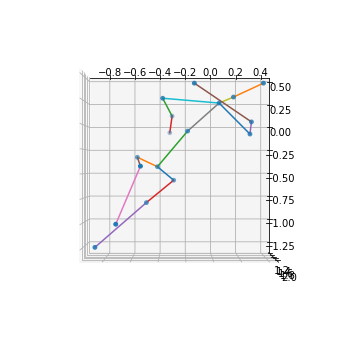

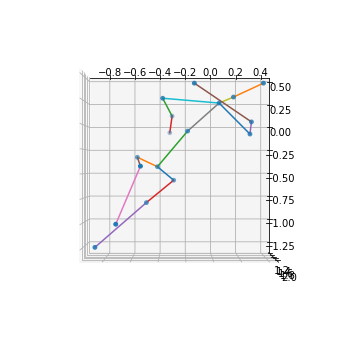

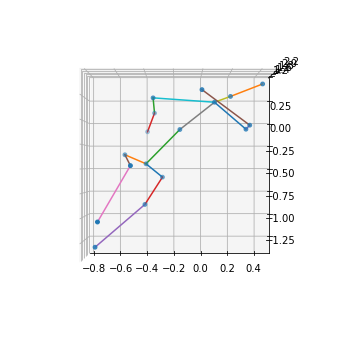

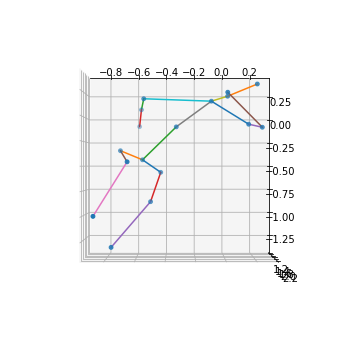

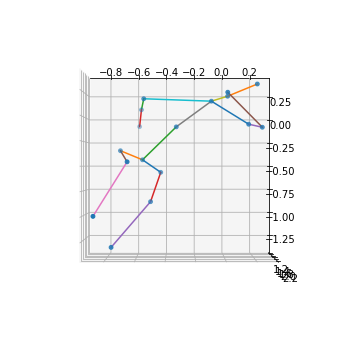

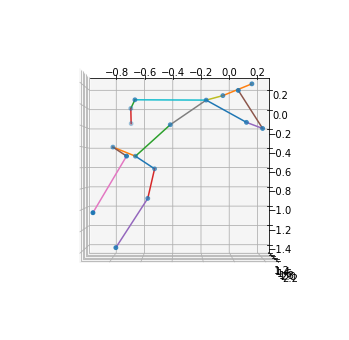

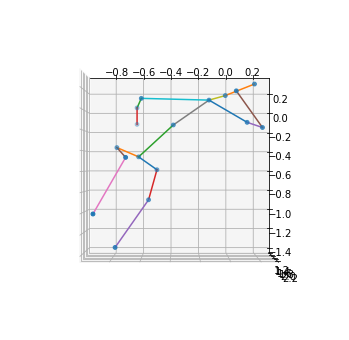

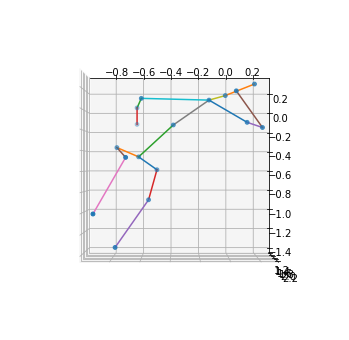

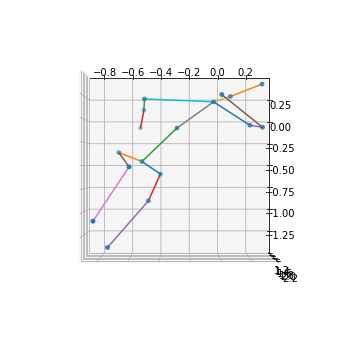

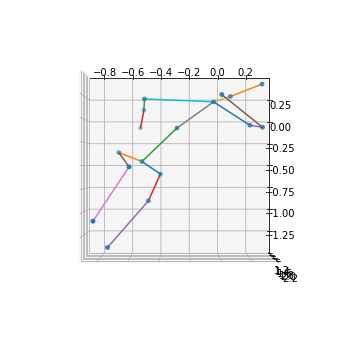

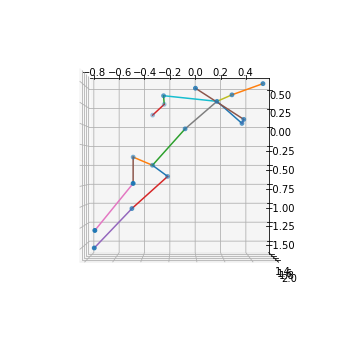

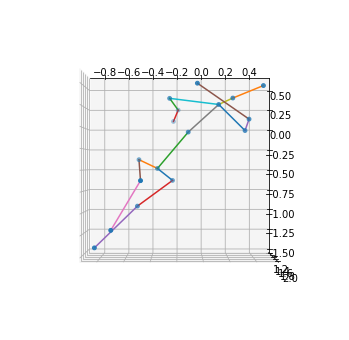

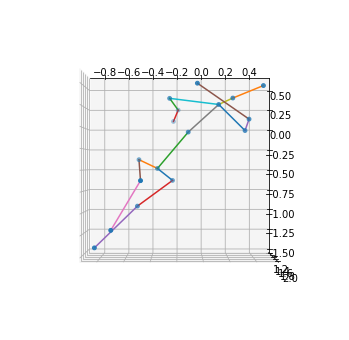

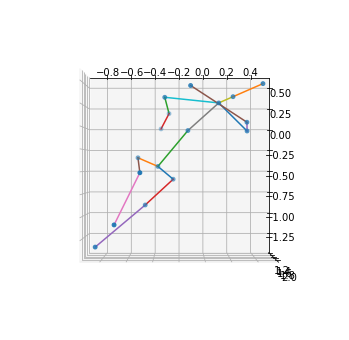

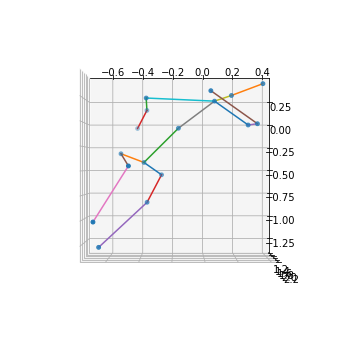

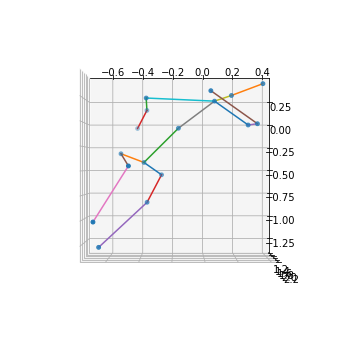

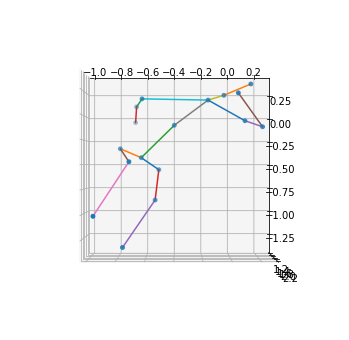

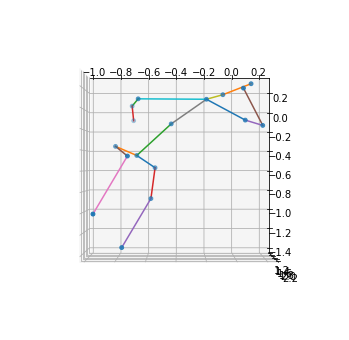

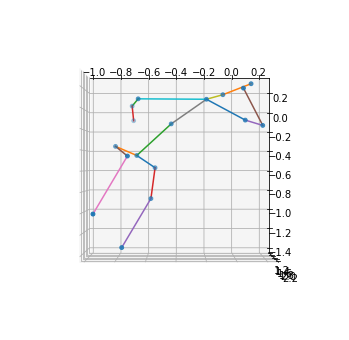

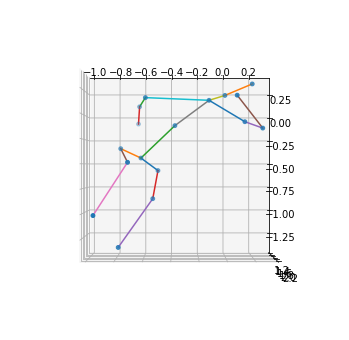

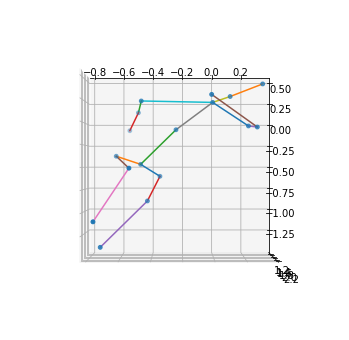

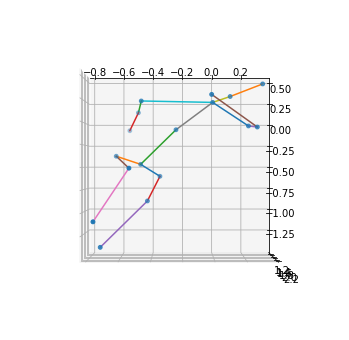

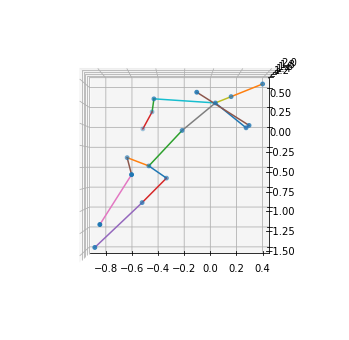

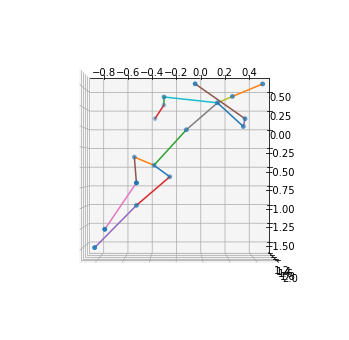

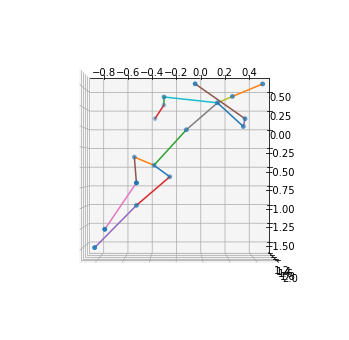

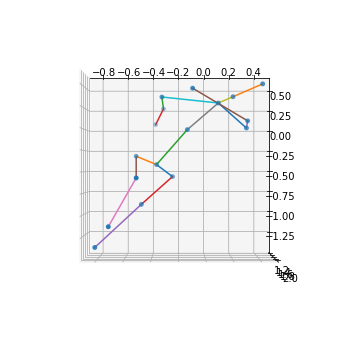

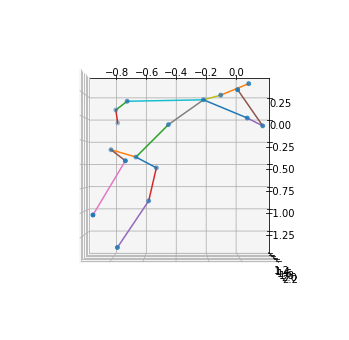

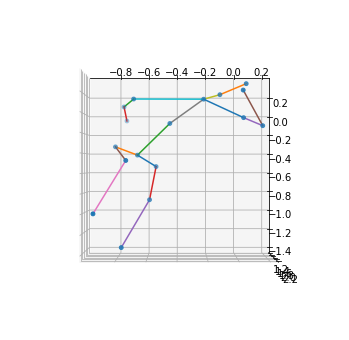

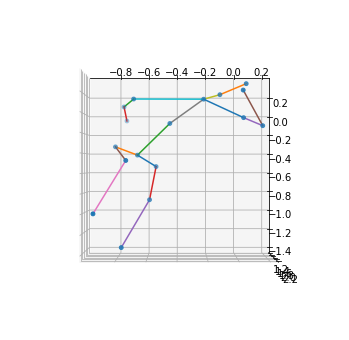

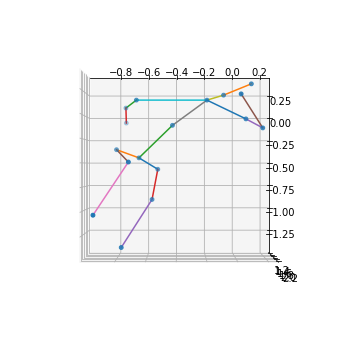

In [ ]:
vision_3d(va)

In [ ]:
video = cv2.VideoCapture("/content/drive/MyDrive/test1.mp4")
count = 0
write_path="/content/drive/MyDrive/test_data/"
while (video.isOpened()):
    # read()는 grab()와 retrieve() 두 함수를 한 함수로 불러옴
    # 두 함수를 동시에 불러오는 이유는 프레임이 존재하지 않을 때
    # grab() 함수를 이용하여 return false 혹은 NULL 값을 넘겨 주기 때문
    ret, image = video.read()
    if ret != True: 
      break
    if (int(video.get(1)) % int(video.get(cv2.CAP_PROP_FRAME_COUNT)/30) == 0):
        #print('Saved frame number : ' + str(int(video.get(1))))
        cv2.imwrite(write_path+"%d.jpg" % count, image)
        #print('Saved frame%d.jpg' % count)
        count += 1
    if count==30:
      video.release()
      break
video.release()

In [ ]:
def making_pose_input(df):
  final_input=[]
  if ((df.iloc[8][0]!= None) & (df.iloc[8][1]!=None))&((df.iloc[11][0] != None) & (df.iloc[11][1] != None)):
    hip=((df.iloc[8][0]+df.iloc[11][0])/2,(df.iloc[8][1]+df.iloc[11][1])/2)
    final_input.append(np.float32(hip))
  else:
    final_input.append((np.nan,np.nan))
  right_hip=df.iloc[8]
  final_input.append(np.float32(right_hip))
  right_knee=df.iloc[9]
  final_input.append(np.float32(right_knee))
  right_foot=df.iloc[10]
  final_input.append(np.float32(right_foot))
  left_hip=df.iloc[11]
  final_input.append(np.float32(left_hip))
  left_knee=df.iloc[12]
  final_input.append(np.float32(left_knee))
  left_foot=df.iloc[13]
  final_input.append(np.float32(left_foot))
  spine=df.iloc[1]
  final_input.append(np.float32(spine))
  if ((df.iloc[1][0] != None)&(df.iloc[1][1] != None))&((df.iloc[0][0] != None)&(df.iloc[0][1] != None)):
    thorax=(df.iloc[1][0]*2-(df.iloc[0][0]+df.iloc[1][0])/2,df.iloc[1][1]*2-(df.iloc[0][1]+df.iloc[1][1])/2)
    final_input.append(np.float32(thorax))
  else:
    final_input.append((np.nan,np.nan))
  head=df.iloc[0]
  final_input.append(np.float32(head))
  left_shoulder=df.iloc[5]
  final_input.append(np.float32(left_shoulder))
  left_elbow=df.iloc[6]
  final_input.append(np.float32(left_elbow))
  left_wrist=df.iloc[7]
  final_input.append(np.float32(left_wrist))
  right_shoulder=df.iloc[2]
  final_input.append(np.float32(right_shoulder))
  right_elbow=df.iloc[3]
  final_input.append(np.float32(right_elbow))
  right_wrist=df.iloc[4]
  final_input.append(np.float32(right_wrist))
  return final_input

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/my_model')

In [ ]:
# 모델의 입력
# 나중에 사용할 수도 있는 label 열도 일단은 생성.
def data2d_import(path):
  # 이미지 읽어오기
  image = cv2.imread(path,cv2.IMREAD_COLOR)
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image2 = cv2.resize(image, dsize=(368, 368), interpolation=cv2.INTER_AREA)
  image3=np.transpose(np.float32(image2[:,:,:,np.newaxis]), (3,0,1,2))
  return image3

def data_to_skeleton(image):
  output=new_model.predict(image)
  H = output[11].shape[1]
  W = output[11].shape[2]
  conf=output[11]
  imageHeight, imageWidth, _ = (368,368,3)
  points = []
  for i in range(0,18):
      # 해당 신체부위 신뢰도 얻음.
      probMap = conf[0, :, :, i]
  
      # global 최대값 찾기
      minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

      # 원래 이미지에 맞게 점 위치 변경
      x = (imageWidth * point[0]) / W
      y = (imageHeight * point[1]) / H     
      points.append((int(x), int(y)))
  return points

def data_to_input(data):
  temp=pd.DataFrame(columns=['x','y'])
  x_list=[]
  y_list=[]
  for i in data:
      x_list.append(i[0])
      y_list.append(i[1])
  temp['x']=x_list
  temp['y']=y_list
  list_temp=making_pose_input(temp)
  a=pd.DataFrame(list_temp,columns=['x','y'])
  return a

In [ ]:
# 입력 데이터 전처리 함수
def input_making(path):
  image=data2d_import(path)
  points=data_to_skeleton(image)
  result=data_to_input(points)
  return result 

In [ ]:
temp=pd.DataFrame(columns=['x','y'])
for k in range(30):
  filepath="/content/drive/MyDrive/test_data/"+str(k)+'.jpg'
  x_temp = input_making(filepath)
  temp=pd.concat([temp,x_temp],axis=0)

In [ ]:
temp.shape

(480, 2)

In [ ]:
test=np.array(temp).reshape(30,16,2)

In [ ]:
test

array([[[212., 176.],
        [200., 176.],
        [200., 256.],
        [200., 336.],
        [224., 176.],
        [224., 256.],
        [216., 336.],
        [208.,  88.],
        [208., 104.],
        [208.,  56.],
        [232.,  88.],
        [232., 128.],
        [232., 160.],
        [192.,  96.],
        [184., 128.],
        [192., 168.]],

       [[212., 180.],
        [200., 184.],
        [200., 256.],
        [200., 336.],
        [224., 176.],
        [224., 256.],
        [216., 336.],
        [208.,  88.],
        [208., 104.],
        [208.,  56.],
        [224.,  88.],
        [232., 112.],
        [208., 104.],
        [192.,  96.],
        [184., 128.],
        [200., 112.]],

       [[212., 176.],
        [200., 176.],
        [200., 256.],
        [200., 336.],
        [224., 176.],
        [224., 256.],
        [224., 336.],
        [208.,  96.],
        [208., 112.],
        [208.,  64.],
        [224.,  88.],
        [240.,  96.],
        [240.,  72.],
      

In [ ]:
test.shape

(30, 16, 2)

In [ ]:
my3d=keras.models.load_model("./drive/MyDrive/save_model/3dpose")
test2=my3d(test)

In [ ]:
test2.shape

TensorShape([30, 51])

In [ ]:
test2=np.array(test2)

In [ ]:
test2=np.array(test2)
test3=test2.reshape(30,17,3)

In [ ]:
test3.shape

(30, 17, 3)

In [ ]:
test2=np.array(test2)
test3=test2.reshape(30,17,3)
test4=test3[np.newaxis,:,:,:]

In [ ]:
test4.shape

(1, 30, 17, 3)

In [ ]:
a5=tf.stack(test4)
a6=tf.transpose(a5,perm=[0,3,1,2])

In [ ]:
a6.shape

TensorShape([1, 3, 30, 17])

In [ ]:
mystgcn.predict(a6)

array([[ 7.0283184, -7.264028 ]], dtype=float32)

기존의 프로젝트에서 OpenPose -> 3D PoseBaseline -> STGCN의 흐름으로 모델을 만들려고했다.

AI 단말기에서 실시간 처리 속도 및 안드로이드 스튜디오 내 추가적인 전처리의 작업으로 인해, 초기 Flask 서버를 이용하여 서비스 제공

하지만, 프로젝트의 방향성을 고수하기위해 서버없이 서비스를 제공하기 위해

단말기 내에서 더 간단한 모델을 사용하여 큐에 데이터가 쌓이는 문제와 처리 속도를 개선함.

Google에서 제공하는 PoseDetection API를 사용했는데, 똑같이 2D 골격구조를 추출하므로, 크게 문제가 없을 것이라 판단했지만, 실제로 학습한 모형에서 평가가 
상이한 결과를 나타냄.

따라서, 단말기 내에서의 흐름대로, PoseDetection을 이용한 모델 학습을 진행해야겠다고 판단함.